# FastAI Cassava Root Disease Classification

<br>

**This notebook contains implementations of ideas from the following papers:**
1. NFNet Architecture --> High-Performance Large-Scale Image Recognition Without Normalization 2021 (https://arxiv.org/abs/2102.06171v1)
2. Gradient Checkpointing --> Low-Memory Neural Network Training: A Technical Report 2019 (https://arxiv.org/abs/1904.10631)
3. MaxBlurPool Layer --> Making Convolutional Networks Shift-Invariant Again 2019 (https://arxiv.org/abs/1904.11486)
4. Mish Activation Function --> Mish: A Self Regularized Non-Monotonic Activation Function 2019 (https://arxiv.org/abs/1908.08681)
5. Swish Activation Function --> Searching for Activation Functions 2017 (https://arxiv.org/abs/1710.05941v2)
6. Rectified Adam Optimizer --> On the Variance of Adaptive Learning Rate and Beyond 2019 (https://arxiv.org/abs/1908.03265)
7. Look Ahead Optimizer --> Lookahead Optimizer: k steps forward, 1 step back 2019 (https://arxiv.org/abs/1907.08610)

<br>

**Major Frameworks used:**
1. FastAI (https://fast.ai)
2. PyTorch (https://pytorch.org)
3. Albumentations (https://albumentations.ai)
4. Timm - PyTorch Image Models (https://github.com/rwightman/pytorch-image-models)

<br>

**With Code Adapted from:**
1. Ross Wightman (https://github.com/rwightman)
2. Zach Mueller (https://github.com/muellerzr)



## Notes

1. We use a large amount of regularization on the test set and a moderate amount on the validation data.  Because we augment the validation data, we expect the straight accuracy to be poor ... in anticipation of performing Test Time Augmentation ensembling.
2. Because we use RAdam, we expect the straight accuracy to be possibly poorer than using Adam but with the hopes of creating a more generalizable model.

In [1]:

## PREVIOUS BEST WITH ACC = 0.87
# RUN_NAME_OF_MODEL_TO_LOAD = '20210210-1221 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=40 bs=8 res=480'
# EPOCH_TO_LOAD = 1


In [2]:
# RUN_NAME_OF_MODEL_TO_LOAD = '20210217-1008 - arch=densenetblur121d - samples=650 frozen=1 epochs=60 bs=32 res=300'
# EPOCH_TO_LOAD = 9

<br>
<br>

In [3]:

from datetime import datetime
import fastai
TEST = False
# ARCH = 'tf_efficientnet_b4_ns'  # resnet101
ARCH = 'tf_efficientnet_b4_ns'
CHOSEN_SAMPLE_SIZE = -1  # 10000 #-1 # 650 #1000  #1800  # use this to control per-category sample sizes # 1000  # deprecated but not removed
TEST_SET_SIZE = round(CHOSEN_SAMPLE_SIZE * 0.2)  # number of images per category to put in the test set
FROZEN_EPOCHS = 1  # 1
EPOCHS = 50  # 4
BATCH_SIZE = 48  # 16
RESOLUTION= 380
PRETRAINED_FLAG = True  # actually False - just to make sure we train a few times before attempting to find LR
GRAD_ACC = 128 # set this to 64 when testing with low data.  Set it to 128, 192 or 256 when using lots of data.

VALID_PERC = 0.2

# data = ''
# rn_addon = f'_data={data}'

time = datetime.today().strftime("%Y%m%d-%H%M")
OLD_RUN_NAME = '20210228-0258 - arch=nf_resnet50 - samples=-1 frozen=2 epochs=30 bs=96 res=400'
RUN_NAME = f'{time} - arch={ARCH} - samples={CHOSEN_SAMPLE_SIZE} frozen={FROZEN_EPOCHS} epochs={EPOCHS} bs={BATCH_SIZE} res={RESOLUTION}'


print(f"RUN_NAME = '{RUN_NAME}'")

RUN_NAME = '20210329-1845 - arch=tf_efficientnet_b4_ns - samples=-1 frozen=1 epochs=50 bs=48 res=380'


In [4]:
import sys
sys.path.append('../utils')

from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from string import ascii_uppercase
import numpy as np
import operator
import glob

import torch
from torch import nn as nn
from torch.nn import functional as F

import gc
# from cassava_utils_eff import *
from nn_utils_eff import *
# from pip_augs import *
from augmentation import *

%matplotlib inline
# %matplotlib widget

plt.rcParams['figure.figsize'] = [9, 5]
plt.rcParams['figure.dpi'] = 120
plt.style.use('dark_background')

import warnings
warnings.filterwarnings('ignore')  # or 'once'  


data_path = Path('../../data')


In [5]:
show_cuda_status()

CUDA available:              True
CUDA device count:           1
Current CUDA Device index:   0
Current CUDA Device:         GeForce RTX 2070 SUPER

fastai version:              2.2.5
cuda version:                10.1
torch version:               1.7.0


<br>
<br>
<br>
<br>

# Data Preparation

<br>
<br>

### Load the Data

In [6]:
classes = ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']

In [7]:

if TEST:
    df = pd.read_csv(f'{data_path}/sample_submission.csv')
else: 
    df = pd.read_csv(f'{data_path}/all_train_files.csv')

cols = df.columns.tolist()
cols = cols[::-1]
df = df[cols]
if not TEST and CHOSEN_SAMPLE_SIZE > 0:
    df = df.sample(n=CHOSEN_SAMPLE_SIZE, replace=False)  # random sample
df.head()

label           image_id
0      0  train-cbb-188.jpg
1      0  train-cbb-255.jpg
2      0  train-cbb-273.jpg
3      0   train-cbb-13.jpg
4      0   train-cbb-76.jpg

<br>
<br>

## @TODO - Create a subset of the data to test on and train ensembles on.  AKA Working Validation Set

After obtaining a baseline and evaluating it on this set, we join it with the rest of the training data to allow the ensemble access to more data.  

In [8]:
# Stratified subset
ensemble_train_df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.16426))

# drop the subset rows
df = df.drop(index=ensemble_train_df.index)

# shuffle and reset index THIS IS DONE LATER
# ensemble_train_df = ensemble_train_df.sample(len(ensemble_train_df)).reset_index(drop=True)
# df = df.sample(len(df)).reset_index(drop=True)
# ensemble_train_df.  @ TODO - what was I doing?

# Re-order the columns in the dataframes
df = pd.DataFrame({'image_id':df.image_id, 'label':df.label})
ensemble_train_df = pd.DataFrame({'image_id':ensemble_train_df.image_id, 'label':ensemble_train_df.label})

len(df), len(ensemble_train_df)

(20348, 4000)

<br>
<br>

## Check the Distribution for Imbalance

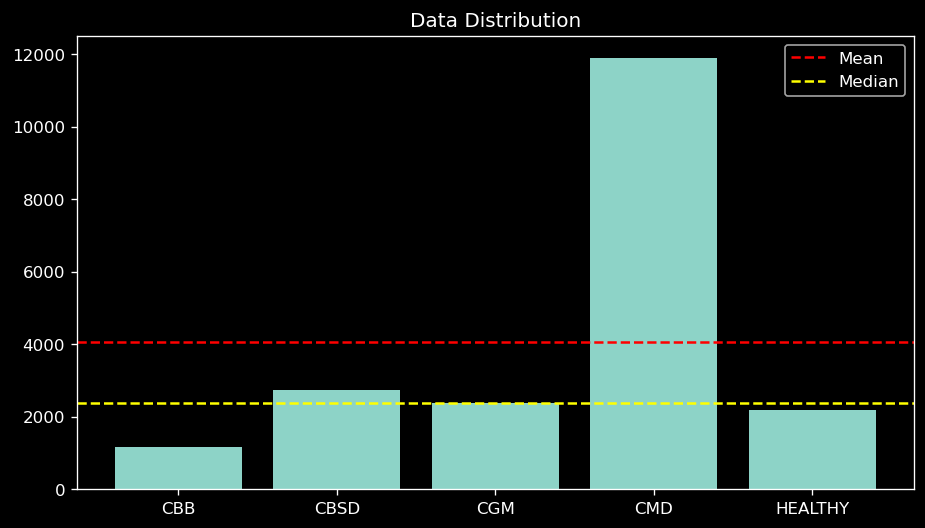

In [9]:
cat_names = ['CBB', 'CBSD', 'CGM', 'CMD', 'HEALTHY']
plt.bar(cat_names, df.loc[:,'label'].value_counts(sort=False))
plt.axhline(df.loc[:,'label'].value_counts().mean(), color='red', ls='--', label='Mean')
plt.axhline(df.loc[:,'label'].value_counts().median(), color='yellow', ls='--', label='Median')
plt.title('Data Distribution')
plt.legend()
plt.show()

<br>
<br>

## Calculate the Relative Weights

Relative Weights: [3.48424658 1.48960469 1.71279461 0.34209818 1.87022059]




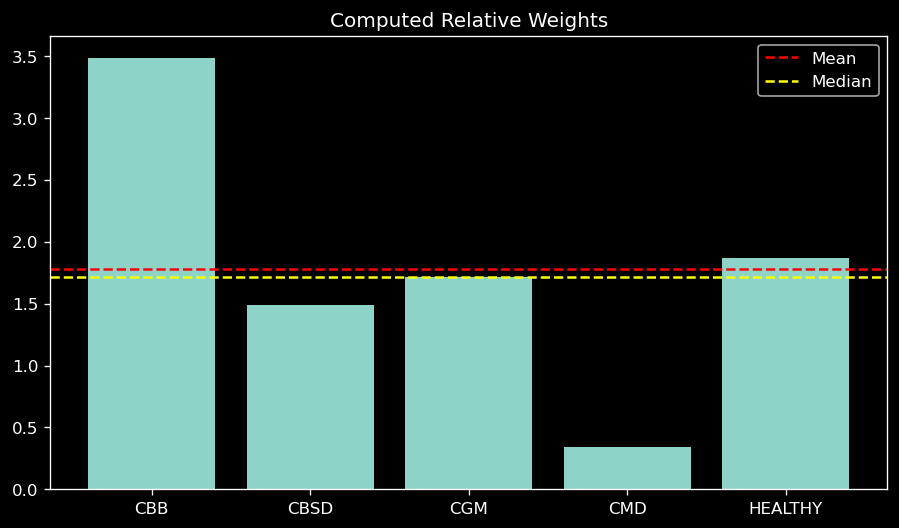

In [10]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', classes=[0,1,2,3,4], y=df.label)
print(f'Relative Weights: {weights}\n\n')

plt.bar(cat_names, weights)
plt.axhline(np.mean(weights), color='red', ls='--', label='Mean')
plt.axhline(np.median(weights), color='yellow', ls='--', label='Median')
plt.title('Computed Relative Weights')
plt.legend()
plt.show()

<br>
<br>

## Hand Tune the outlier weights

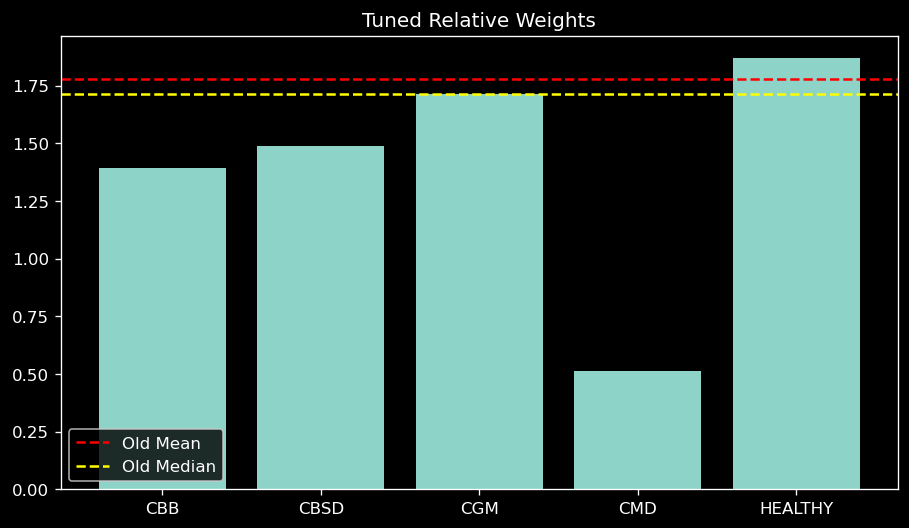

In [11]:
tuned_weights = weights.copy()
tuned_weights[0] = tuned_weights[0] * 0.4
tuned_weights[3] = tuned_weights[3] * 1.5

plt.bar(cat_names, tuned_weights)
plt.axhline(np.mean(weights), color='red', ls='--', label='Old Mean')
plt.axhline(np.median(weights), color='yellow', ls='--', label='Old Median')
plt.title('Tuned Relative Weights')
plt.legend()
plt.show()

<br>
<br>

## Calculate the new Weighted Distribution

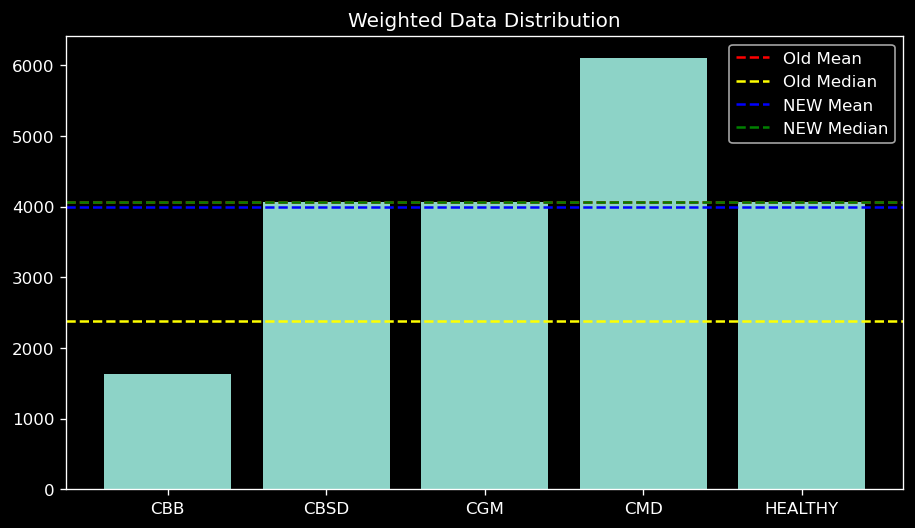

In [12]:
weighted_dist = tuned_weights * df.loc[:,'label'].value_counts(sort=False)

plt.bar(cat_names, weighted_dist)
plt.axhline(df.loc[:,'label'].value_counts().mean(), color='red', ls='--', label='Old Mean')
plt.axhline(df.loc[:,'label'].value_counts().median(), color='yellow', ls='--', label='Old Median')
plt.axhline(np.mean(weighted_dist), color='blue', ls='--', label='NEW Mean')
plt.axhline(np.median(weighted_dist), color='green', ls='--', label='NEW Median')
plt.title('Weighted Data Distribution')
plt.legend()
plt.show()

In [13]:
# convert the tuned weights to a tensor
tuned_weights = Tensor(tuned_weights).cuda()
tuned_weights

tensor([1.3937, 1.4896, 1.7128, 0.5131, 1.8702], device='cuda:0')

<br>
<br>

## Oversample the weak classes

In [14]:
df0 = df[df.label == 0]
df4 = df[df.label == 4]
df_rest = df[df.label.isin([1,2,3])]

In [15]:
df0 = pd.concat([df0,df0, df0.sample(frac=0.8)]) 
df4 = pd.concat([df4,df4.sample(frac=0.6)])
df = pd.concat([df0,df_rest,df4])
df = df.sample(frac=1)  # shuffle

## Create a list of image paths

In [16]:
train_imgs = L([Path(data_path/'train_images'/f) for f in df.image_id])
random.shuffle(train_imgs)

In [17]:
ensemble_train_imgs = L([Path(data_path/'train_images'/f) for f in ensemble_train_df.image_id])
random.shuffle(ensemble_train_imgs)

<br>
<br>

In [18]:
# get the label from any image path  @TODO sloooooowwwwww......

def get_label(o):
    fname = o.name
    if fname in df.image_id.values:
        return df[df.image_id == fname].label.values[0]
    if fname in ensemble_train_df.image_id.values:
        return ensemble_train_df[ensemble_train_df.image_id == fname].label.values[0]


<br>
<br>
<br>
<br>

# Model Development

<br>
<br>

## Create the Transforms

In [19]:
item_tfms = [ToTensor(), AlbumentationsTransform(get_train_aug(RESOLUTION), get_valid_aug(RESOLUTION))]
batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

# item_tfms = [ToTensor(), AlbumentationsTransform(get_train_aug(RESOLUTION), get_valid_aug(RESOLUTION))]
# batch_tfms = [Normalize.from_stats(*imagenet_stats)]

<br>
<br>

## Create the Splitter

In [20]:
start_val = len(train_imgs) - int(len(train_imgs) * VALID_PERC)
idcs = list(range(start_val, len(train_imgs)))
splitter = IndexSplitter(idcs)
splits = splitter(train_imgs)
split_list = [splits[0], splits[1]]

split_list.append(L(range(len(train_imgs), len(train_imgs)+len(ensemble_train_imgs))))


The following should show 3 datasets
1. Training Set
2. Working Validation Set
3. Working Test Set

In [21]:
split_list

[(#18445) [0,1,2,3,4,5,6,7,8,9...],
 (#4611) [18445,18446,18447,18448,18449,18450,18451,18452,18453,18454...],
 (#4000) [23056,23057,23058,23059,23060,23061,23062,23063,23064,23065...]]

In [22]:
split_list[0][0], split_list[0][-1], split_list[1][0], split_list[1][-1], split_list[2][0]

(0, 18444, 18445, 23055, 23056)

<br>
<br>

## Create the Data Loaders

In [23]:
dsrc = Datasets(train_imgs+ensemble_train_imgs, tfms=[[PILImage.create], [get_label, Categorize]],
                splits = split_list)

dls = dsrc.dataloaders(bs=BATCH_SIZE, after_item=item_tfms, after_batch=batch_tfms)

In [24]:
train_labels = list(df.label.values)
train_labels.extend(ensemble_train_df.label.values)

<br>

### Verify the Training and Validation Batches

examples from the training set


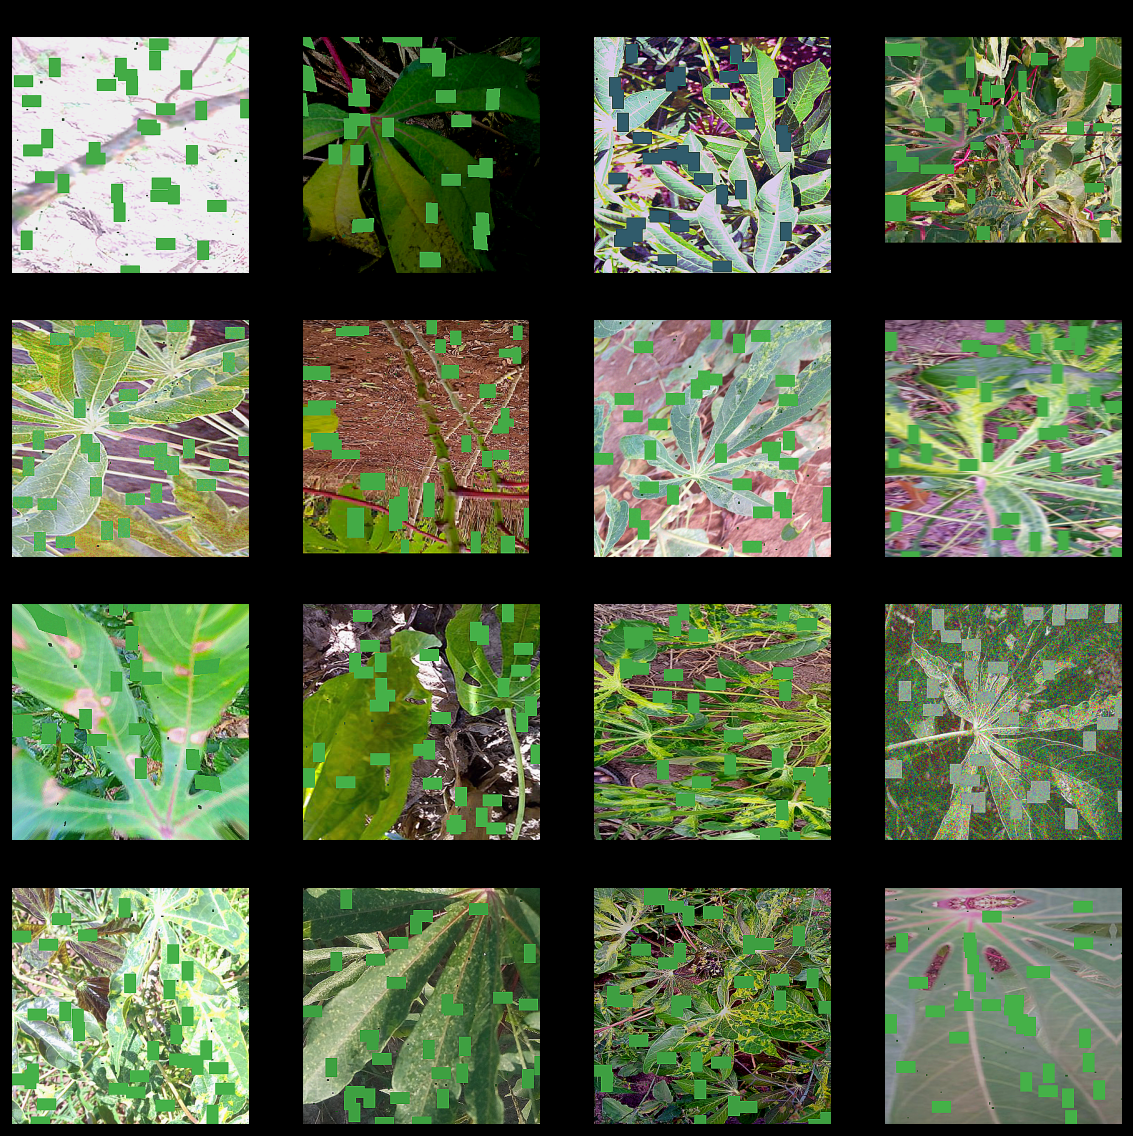

In [25]:
print('examples from the training set')
dls.train.show_batch(max_n=16, nrows=4)


examples from the validation set


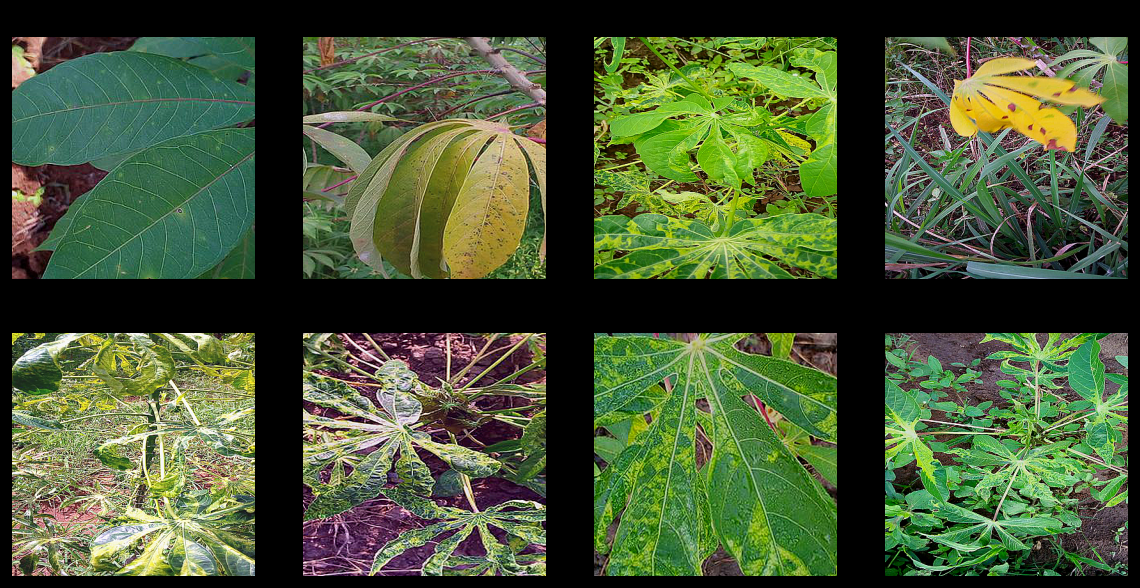

In [26]:
print('\nexamples from the validation set')
dls.valid.show_batch(max_n=8, nrows=2)

<br>
<br>

## Create our Callbacks

In [28]:
cutmix_cb = None
mixup_cb = None

def create_callbacks():
    global cutmix_cb, mixup_cb

    # Eary stopping callback
    early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', patience=5, reset_on_fit=True)

    # Save the current model's weights every epoch
    save_cb = SaveModelCallback(fname=RUN_NAME, with_opt=True, every_epoch=True)

    # Reduce the Learning Rate if valid_loss flatlines
    reduceLR_cb = ReduceLROnPlateau(monitor='valid_loss', min_delta=0.01, min_lr=1e-8, patience=3, factor=10, reset_on_fit=True)

    # Mixup callback for regularization
    # mixup_cb = MixUp(alpha=0.3)
    mixup_cb = None

    # Cutmix callback for regularization
    cutmix_cb = CutMix()
#     cutmix_cb = None

    # Gradient Accumulation
    # gradacc_cb =  GradientAccumulation(n_acc=16)
    gradacc_cb =  GradientAccumulation(n_acc=128)
  
    # log our runs
    csv_log_cb = CSVLogger(fname=f'CSV-History/{RUN_NAME}.csv', append=True)


    # List of callbacks to be used later
    cbs = [save_cb, ShowGraphCallback(), GradientClip(), early_stop_cb, gradacc_cb]  #, reduceLR_cb, early_stop_cb, csv_log_cb] #, reduceLR_cb]

    if mixup_cb != None:
        cbs.insert(0, mixup_cb)

    if cutmix_cb != None:
        cbs.insert(0, cutmix_cb)

    print('\nAll Callbacks: ', cbs)
    return cbs

# empty
cbs = create_callbacks()


All Callbacks:  [CutMix, SaveModelCallback, ShowGraphCallback, GradientClip, EarlyStoppingCallback, GradientAccumulation]


### Visualize the effect of CutMix


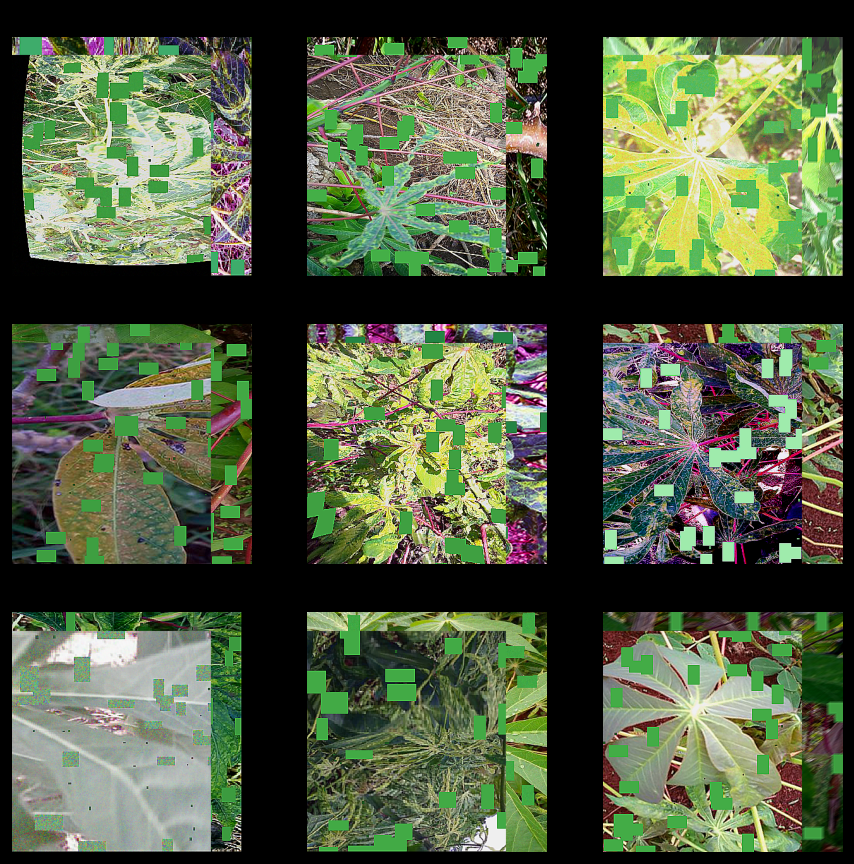

In [29]:
if cutmix_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cutmix_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(cutmix_cb.x,cutmix_cb.y), ctxs=axs.flatten())
 
else: print('\n CutMix was not selected.')

<br>

### Visualize the Effect of MixUp

MixUp creates a linear interpolation between the target data and another datapoint.  In images, it shows up as ghostly figures.  The technique has been shown to be a good to decrease the liklihood of overfitting.

In [30]:
if mixup_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(mixup_cb.x,mixup_cb.y), ctxs=axs.flatten())

else: print('\n MixUp was not selected.')


 MixUp was not selected.


<br>
<br>

<br>
<br>

# Model Instantiation

<br>
<br>

In [31]:


# from torch.utils.checkpoint import checkpoint, checkpoint_sequential

# class CheckpointModule(Module):
#     def __init__(self, module, num_segments=1):
#         assert num_segments == 1 or isinstance(module, nn.Sequential)
#         self.module = module
#         self.num_segments = num_segments

#     def forward(self, *inputs):
#         if self.num_segments > 1:
#             return checkpoint_sequential(self.module, self.num_segments, *inputs)
#         else:
#             return checkpoint(self.module, *inputs)
        
        
    
# def convert_seq_chkpt(model, layer_type_old):  
#     conversion_count = 0
#     for name, module in reversed(model._modules.items()):
#         if len(list(module.children())) > 0:
#             # recurse
#             model._modules[name] = convert_seq_chkpt(module, layer_type_old) 

#         if type(module) == layer_type_old:
# #             num_chkpt += 1
#             layer_old = module
# #             if len(layer_old) == 7:
# #                 segments = 1
# #             else: segments = len(layer_old)
#             segments = len(layer_old)
#             layer_new = CheckpointModule(layer_old, segments)  # wrap sequential in a checkpoint module
#             model._modules[name] = layer_new
# #             print(segments)

#     return model

In [32]:
custom_head = nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    Flatten(full=False),
    nn.BatchNorm1d(1792, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.Dropout(p=0.7, inplace=False),
    nn.Linear(in_features=1792, out_features=64, bias=False),
    MishAuto(inplace=True),
    nn.BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.Dropout(p=0.6, inplace=False),
    nn.Linear(in_features=64, out_features=5, bias=True)
)

In [33]:
import timm

def create_learner(cat_weights=tuned_weights):
    # Create the learner
    learn = timm_learner(dls, 
                         ARCH,
                         opt_func=ranger, custom_head=custom_head,
                         loss_func=LabelSmoothingCrossEntropyFlat(weight=cat_weights),
#                          loss_func=LabelSmoothingCrossEntropyFlat(),
                          cbs=create_callbacks(), 
                         pretrained=PRETRAINED_FLAG,
                         metrics = [error_rate, accuracy, RocAuc()]
                        )


    # Learner Surgery - replacing modules
    learn.model[0] = convert_seq_chkpt(learn.model[0], nn.Sequential)  # hack in gradient checkpoints for memory savings
#    learn.model[0] = nn.Sequential(CheckpointModule(learn.model[0], 1))  # hack in the final checkpointmodule for the base sequence

    learn = convert_MP_to_blurMP(learn, nn.MaxPool2d)  # replace max pool with with BlurMaxPool (if it exists)
    learn.model[1] = convert_act_cls(learn.model[1], nn.ReLU, MishAuto())  # very expensive so we only use it on the head
    learn.model[0] = convert_act_cls(learn.model[0], nn.ReLU, SwishAuto())  # replace with a lower memory version (not needed for effnet)
    
#    learn = learn.to_fp16()  # convert to mixed precision for memory savings

    learn = learn.to_non_native_fp16()

    return learn


In [34]:
learn = create_learner()


All Callbacks:  [CutMix, SaveModelCallback, ShowGraphCallback, GradientClip, EarlyStoppingCallback, GradientAccumulation]


In [35]:
display(learn.loss_func, learn.opt_func, learn.cbs) #, '-------------------------------------', learn.model)  # Checkpoint

FlattenedLoss of LabelSmoothingCrossEntropy()

<function fastai.optimizer.ranger(p, lr, mom=0.95, wd=0.01, eps=1e-06, sqr_mom=0.99, beta=0.0, decouple_wd=True)>

(#11) [TrainEvalCallback,Recorder,ProgressCallback,CutMix,SaveModelCallback,ShowGraphCallback,GradientClip,EarlyStoppingCallback,GradientAccumulation,ModelToHalf...]

In [36]:
learn.model[1]

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(full=False)
  (2): BatchNorm1d(1792, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.7, inplace=False)
  (4): Linear(in_features=1792, out_features=64, bias=False)
  (5): MishAuto()
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.6, inplace=False)
  (8): Linear(in_features=64, out_features=5, bias=True)
)

In [37]:
# # RUN_NAME_OF_MODEL_TO_LOAD = '20210211-0115 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=15 bs=12 res=460'
# EPOCH_TO_LOAD = 7

# load_model(f'models/{OLD_RUN_NAME}.pth', learn, opt=ranger, with_opt=True)
# learn.remove_cbs(CutMix)


<br>
<br>
<br>
<br>

# ------------------ RUN TO HERE -------------------

# Model Training

<br>
<br>
<br>

## Find a Good Learning Rate to Start With

In [ ]:
LR_DIV = 14e0  # Shift the lr_min left by this amount.  Adjust as necessary
lr_min = 0.002  # just a default

In [ ]:
# from apex.fp16_utils import convert_network
# learn.model = convert_network(learn.model, torch.float16)

In [ ]:
# learn = learn.to_fp16()

### This is what it looks like with no gradacc, 120px and batch size=128
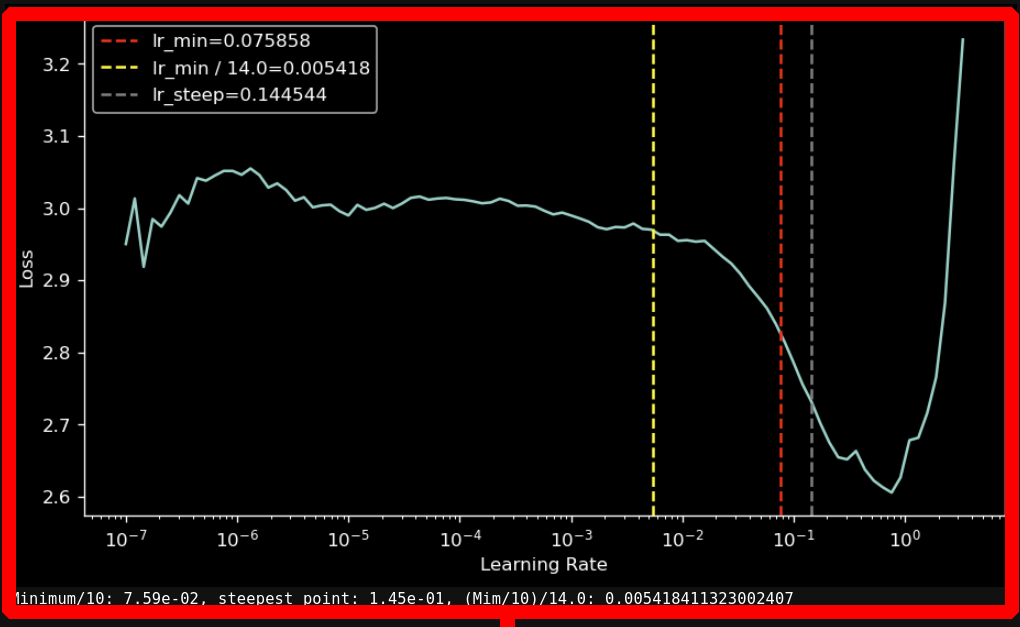

In [ ]:
if PRETRAINED_FLAG == True:
    learn.freeze()
    lr_min,lr_steep = learn.lr_find()
    plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
    plt.axvline(lr_min/LR_DIV, ls='--', color='yellow', label=f'lr_min / {LR_DIV}={round(lr_min/LR_DIV,6)}')
    plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
    plt.legend()
    plt.show()

    print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}, (Mim/10)/{LR_DIV}: {lr_min/LR_DIV}")

<br>
<br>

# Pick a Good Initial Learning Rate

In [38]:
# LR_CHOICE = lr_min/LR_DIV
# LR_CHOICE = lr_steep
# LR_CHOICE = 9e-3
# LR_CHOICE = 2e-4
# LR_CHOICE = 4e-2
LR_CHOICE=7e-3  # working and conservative - we deliberately want a long training run

<br>
<br>

<br>
<br>

# Training the Model

<br>

## Fit the last layers, unfreeze, fit the whole net, with a decent initial LR, all in one go.



In [39]:
if PRETRAINED_FLAG:
    print(f'FROZEN_EPOCHS:  {FROZEN_EPOCHS}')
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE}\n\n')

FROZEN_EPOCHS:  1
EPOCHS:         50
Learning Rate:  0.007




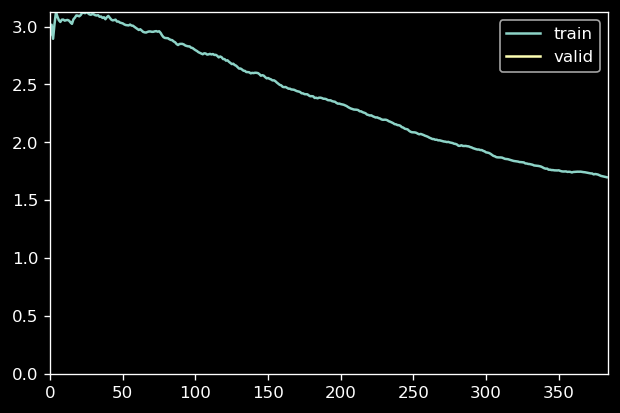

Max GPU Memory Allocated: 3.480062976 GB


In [40]:
if PRETRAINED_FLAG:
    learn.fit_flat_cos(FROZEN_EPOCHS, LR_CHOICE, pct_start=0.99, wd=0.01, reset_opt=True)
#     fit_hump(learn, 1, lr_max=LR_CHOICE, reset_opt=True)
#     learn.fit_one_cycle(FROZEN_EPOCHS, slice(LR_CHOICE), wd=0.1)

    print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
    torch.cuda.reset_max_memory_allocated()

<br>
<br>

## Manually set up the unfrozen runs

In [41]:
learn.unfreeze()

We note that the use of Gradient Checkpointing obfuscates the learning rate finder but we leave it here anyway.

In [ ]:
lr_min,lr_steep = learn.lr_find()
plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
# plt.axvline(LR_CHOICE/2, ls='--', color='yellow', label=f'LR_CHOICE/2={round(LR_CHOICE/2,6)}')
plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
plt.axvline(2e-5, ls='--', color='green', label=f'{round(2e-5,6)}')
plt.axvline(7e-5, ls='--', color='orange', label=f'{round(7e-5,6)}')

plt.legend()
plt.show()

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest po00⁰LR_CHOICE/2: {LR_CHOICE / 2}")

In [43]:
# Persist a Copy

# Need to do this first as it won't pickle
# learn.remove_cbs(CSVLogger)

learn.export(f'models/STAGE1_{RUN_NAME}.pkl')
print(f'Saved to: models/STAGE1_{RUN_NAME}.pkl')

# put the logger back in
# learn.add_cbs(CSVLogger(fname=f'{RUN_NAME}.csv', append=True))

Saved to: models/STAGE1_20210329-1845 - arch=tf_efficientnet_b4_ns - samples=-1 frozen=1 epochs=50 bs=48 res=380.pkl


## Pick a new Learning Rate

In [44]:
# LR_CHOICE_UNFROZ = 9e-3
# LR_CHOICE_UNFROZ = 3e-3
# LR_CHOICE_UNFROZ = 4e-3
# LR_CHOICE_UNFROZ = 6e-3
#LR_CHOICE_UNFROZ = 5e-4  # working on normal, working blut slow on checkpoints
# LR_CHOICE_UNFROZ = 4e-3  # testing for checkpoints --> too erratic
LR_CHOICE_UNFROZ = 8e-4  # testing for checkpoints



# Train

In [45]:
#EPOCHS = 400

In [46]:
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE_UNFROZ}\n\n')

EPOCHS:         50
Learning Rate:  0.004




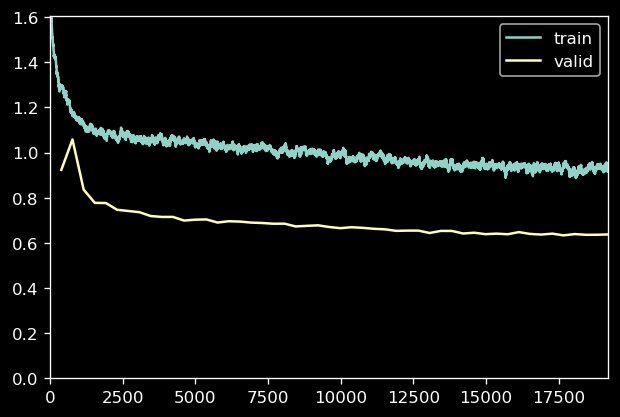

Max GPU Memory Allocated: 3.906661376 GB


In [47]:
# learn.fit_flat_cos(EPOCHS, slice(LR_CHOICE_UNFROZ), pct_start=0.68)

# learn.fit_one_cycle(EPOCHS, slice(LR_CHOICE_UNFROZ),  wd=1e-2)

learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ, pct_start=0.4, wd=1e-2, reset_opt=False)
# fit_hump(learn, EPOCHS, lr_max=LR_CHOICE_UNFROZ, reset_opt=True)

print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
torch.cuda.reset_max_memory_allocated()

<br>
<br>

## Persist the Model

In [49]:

# save the raw version
learn.export(f'../models/{RUN_NAME}-WITH_CBS.pkl')

# save a version for inferrences only
c = remove_cbs(learn)
learn.export(f'../models/{RUN_NAME}.pkl')
with open(f'models/DLS/{RUN_NAME}-DLS.pkl', 'wb') as f:
    pickle.dump(learn.dls, f)  # save the data loaders as they hold the split data
    
# path = Path('../models')
# path.ls(file_exts='.pkl')

In [ ]:
# LR_CHOICE_UNFROZ = 9e-3
# LR_CHOICE_UNFROZ = 3e-3
# LR_CHOICE_UNFROZ = 4e-3
# LR_CHOICE_UNFROZ = 6e-3
# LR_CHOICE_UNFROZ = 5e-4  # working on normal, working blut slow on checkpoints
# LR_CHOICE_UNFROZ = 1e-2  # testing for checkpoints --> too erratic
LR_CHOICE_UNFROZ = 2e-3  # testing for checkpoints 2e-3 worked



# Train 2

In [ ]:
EPOCHS = 60

In [ ]:
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE_UNFROZ}\n\n')

In [ ]:
# learn.fit_flat_cos(EPOCHS, slice(LR_CHOICE_UNFROZ), pct_start=0.68)

# learn.fit_one_cycle(EPOCHS, slice(LR_CHOICE_UNFROZ),  wd=1e-2)

learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ, pct_start=0.7, wd=1e-1, reset_opt=True)
# fit_hump(learn, EPOCHS, lr_max=LR_CHOICE_UNFROZ, reset_opt=True)

print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
torch.cuda.reset_max_memory_allocated()

In [ ]:
# LR_CHOICE_UNFROZ = 9e-3
# LR_CHOICE_UNFROZ = 3e-3
# LR_CHOICE_UNFROZ = 4e-3
# LR_CHOICE_UNFROZ = 6e-3
# LR_CHOICE_UNFROZ = 5e-4  # working on normal, working blut slow on checkpoints
# LR_CHOICE_UNFROZ = 1e-2  # testing for checkpoints --> too erratic
LR_CHOICE_UNFROZ = 5e-3  # testing for checkpoints 2e-3 worked



# Train 3

In [ ]:
EPOCHS = 60

In [ ]:
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE_UNFROZ}\n\n')

In [ ]:
# learn.fit_flat_cos(EPOCHS, slice(LR_CHOICE_UNFROZ), pct_start=0.68)

# learn.fit_one_cycle(EPOCHS, slice(LR_CHOICE_UNFROZ),  wd=1e-2)
learn.unfreeze()
learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ, pct_start=0.5, wd=1e-1, reset_opt=False)
# fit_hump(learn, EPOCHS, lr_max=LR_CHOICE_UNFROZ, reset_opt=True)

print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
torch.cuda.reset_max_memory_allocated()

In [ ]:
learn.recorder.plot_sched()

In [ ]:
learn.save(f'{RUN_NAME}_model1')  #_acc{round(learn.validate(ds_idx=2)[2],2)}')

<br>
<br>

# 5-Fold Cross-Validation + Ensemble

Here we use 5-fold cross-validation to maximize data exposure while remaining leak free as well as to create an ensemble who's sum is greater than the parts.  Note that because we're doing N-Fold, we start by combining the train_ensemble data to the training data and because of that - we can no longer truly use it as a validation set.  However, we can use the nth fold

Luckily, we split the data earlier (before this notebook and not even loaded yet) and we can use that to validate.  Eventually, we'll train on even the holdout data before submitting to Kaggle to test against their unexposed test data.

In [ ]:
from sklearn.model_selection import StratifiedKFold

LR_CHOICE=7e-3
LR_CHOICE_UNFROZ = 6e-3
FROZEN_EPOCHS = 2
EPOCHS = 5

skf = StratifiedKFold(n_splits=5, random_state = 42, shuffle=True)
i = 0
tw_flag = None
val_pct = []
tst_preds = []

record_df = pd.DataFrame(columns=['RUN_NAME', 'split num', 'epoch', 'loss', 'accuracy', 'roc_auc', 'tuned weights bool'])

for _, val_idx in skf.split(np.array(train_imgs+ensemble_train_imgs), train_labels):
    i += 1
    
    print('\n\n\n')
    print(f'-----------------------------------')
    print(f'------------ SPLIT {i} -------------')
    print(f'-----------------------------------')

    # sort out the data
    splits = IndexSplitter(val_idx)
    split = splits(train_imgs)
    split_list = [split[0], split[1]]
    split_list.append(L(range(len(train_imgs), len(train_imgs)+len(ensemble_train_imgs))))
    dsrc = Datasets(train_imgs+ensemble_train_imgs, tfms=[[PILImage.create], [get_label, Categorize]],
                  splits=split_list)
    dls = dsrc.dataloaders(bs=BATCH_SIZE, after_item=item_tfms, after_batch=batch_tfms)

    # Create a brand new learner model each time
    if torch.rand(1)[0] > 0.5:
        learn = create_learner(cat_weights=tuned_weights)
        tw_flag = True
    else:
        learn = create_learner(cat_weights=None)
        tw_flag = False
     
    # fit just the new head
    if PRETRAINED_FLAG == True:
        learn.freeze()
        learn.fit_flat_cos(FROZEN_EPOCHS, LR_CHOICE, pct_start=0.99, wd=0.1, reset_opt=True)
        
    learn.unfreeze()
    
    # persist
    learn.export(f'models/{RUN_NAME}_split_{i}.pkl')
    learn.save(f'{RUN_NAME}_STAGE1_split{i}_acc{round(learn.validate(ds_idx=2)[2],2)}')
    print(f'Saved to: ../models/{RUN_NAME}_split_{i}.pkl')


    # fit a series of short-run models to ensemble later.  Also simulates cos annealing with warm restarts
    for ep in range(5, 35, 5):
        
        print(f'\n\n------> EPOCH: {ep-5} - {ep}\n')

        if ep == 5:
            learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ, pct_start=0.9, wd=1e-1, reset_opt=False)
        elif ep <= 20:
            learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ, pct_start=0.7, wd=1e-1, reset_opt=False)
        elif ep == 25:
            learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ/10, pct_start=0.6, wd=1e-2, reset_opt=False)
        elif ep == 30: 
            learn.fit_flat_cos(EPOCHS+3, LR_CHOICE_UNFROZ/100, pct_start=0.5, wd=1e-2, reset_opt=False)

            
               
        # save 
        learn.save(f'{RUN_NAME}_split_{i}_epoch{ep}_acc{round(learn.validate(ds_idx=2)[2],2)}')
        
        # save stats
        val = learn.validate()
        record_df.loc[len(record_df.index)] = [RUN_NAME, i, ep, val[0], val[2], val[3], tw_flag]
        record_df.to_csv(f'CSV-History/{RUN_NAME}_record.csv')
        
        # print validation info
#         print(f'Validation on train: {learn.validate(0)}')
#         print(f'Validation on valid: {val}')
        print(f'Validation on test: {learn.validate(2)}')
   
#     learn.recorder.plot_sched()
    
    # Save the validation information to cross validate with
    val_pct.append(learn.validate()[2])
    a,b = learn.get_preds(ds_idx=2)
    tst_preds.append(a)

<br>
<br>

<br>

# -------------------- TRAIN AGAIN -----------------

<br>

<br>
<br>

### Train again

In [ ]:
# save_model("test.pth", learn, learn.opt, with_opt=True)

In [ ]:
# learn = load_learner(f'../models/{RUN_NAME}.pkl', cpu=False)
#
    # RUN_NAME_OF_MODEL_TO_LOAD = '20210210-2234 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=15 bs=12 res=460'
    # EPOCH_TO_LOAD = 9

# load_model(f'models/{RUN_NAME_OF_MODEL_TO_LOAD}_{EPOCH_TO_LOAD}.pth', learn, opt=ranger, with_opt=False)

# load_model(f'models/{RUN_NAME}_8.pth', learn, opt=ranger, with_opt=True)
# learn = load_learner(f'../models/{RUN_NAME}.pkl', cpu=False)
# load_model(f'test.pth', learn, opt=ranger, with_opt=True)

# load_model(f'models/20210213-2138 - arch=efficientnet_b3a - samples=1800 frozen=3 epochs=60 bs=32 res=400_9.pth', learn, opt=ranger, with_opt=True)

learn.dls = dls
learn.remove_cbs(cbs)
learn.add_cbs(cbs)

learn.opt.clear_state()


In [ ]:
learn.unfreeze()

In [ ]:
# learn.dls = dls_findlr
lr_min,lr_steep = learn.lr_find()
plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
# plt.axvline(LR_CHOICE/2, ls='--', color='yellow', label=f'LR_CHOICE/2={round(LR_CHOICE/2,6)}')
plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
plt.axvline(2e-5, ls='--', color='green', label=f'{round(2e-5,6)}')
plt.axvline(7e-5, ls='--', color='orange', label=f'{round(7e-5,6)}')

plt.legend()
plt.show()


learn.dls = dls
del dls_findlr
gc.collect()
torch.cuda.empty_cache()
gc.collect()


In [ ]:
EPOCHS = 20
LR_CHOICE_UNFROZ = 7e-3

In [ ]:
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE_UNFROZ}\n\n')

In [ ]:
# learn.fit_flat_cos(EPOCHS, slice(LR_CHOICE_UNFROZ), pct_start=0.68)

# learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ, pct_start=0.2, wd=0.1) # , reset_opt=True)
fit_hump(learn, EPOCHS, lr_max=LR_CHOICE_UNFROZ, reset_opt=False)

print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
torch.cuda.reset_max_memory_allocated()

<br>
<br>

## Persist the Model

In [ ]:
learn.export(f'../models/{RUN_NAME}.pkl')
print(f'Saved to: ../models/{RUN_NAME}.pkl')

# path = Path('../models')
# path.ls(file_exts='.pkl')

<br>
<br>

### Show some Results

In [ ]:
learn.show_results()


<br>
<hr>
<br>
<br>
<br>

# Validation Set (not test set) Analysis

<br>

### Plot Losses

In [ ]:
# learn.recorder.plot_loss()
# plt.ylabel('Loss')
# plt.xlabel('Batches Processed')

In [ ]:
c = learn.cbs
c

In [ ]:
def _remove_cbs(le=learn):
    _cbs = le.cbs
    
    le.remove_cbs(CutMix)
    le.remove_cbs(SaveModelCallback)
    le.remove_cbs(ShowGraphCallback)
    le.remove_cbs(EarlyStoppingCallback)
    le.remove_cbs(GradientAccumulation)
    return _cbs

In [ ]:
orig_cbs = _remove_cbs()

<br>

### Visualize with a confusion Matrix

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

In [ ]:
interp.most_confused()[:10]

<br>
<br>

## Classification Report

In [ ]:
interp.print_classification_report()

<br>

### Show the top 15 most error prone images

In [ ]:
interp.plot_top_losses(15, nrows=5)

<br>
<br>
<br>
<br>

# ----------------- Validation ------------

<br>
<br>

<br>

In [ ]:
VALID_RESOLUTION = 380
VALID_BATCH_SIZE = 12

test_learn = learn

In [ ]:
# RUN_NAME_OF_MODEL_TO_LOAD = '20210227-0137 - arch=nf_resnet50 - samples=-1 frozen=1 epochs=50 bs=32 res=256_model1_acc0.89'
# load_learner('../models/{RUN_NAME}.pkl', cpu=False)
# load_model(f'models/{RUN_NAME_OF_MODEL_TO_LOAD}.pth', test_learn, opt=ranger, with_opt=False)
test_learn.remove_cbs(test_learn.cbs)
test_learn.remove_cbs(test_learn.cbs)
test_learn.remove_cbs(test_learn.cbs)
test_learn.remove_cbs(test_learn.cbs)

In [ ]:
def get_train_aug_test(): return A.Compose([
            A.RandomResizedCrop(VALID_RESOLUTION,VALID_RESOLUTION, scale=(0.2, 1)),
            A.Transpose(p=0.7),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.7),
            A.HueSaturationValue(
                hue_shift_limit=0.3, 
                sat_shift_limit=0.3, 
                val_shift_limit=0.3, 
                p=0.7
            ),
            A.RandomBrightnessContrast(
                brightness_limit=(-0.2,0.2), 
                contrast_limit=(-0.2, 0.2), 
                p=0.7
            ),
            A.CoarseDropout(p=0.8, max_holes=20),
            A.Cutout(p=0.8, max_h_size=12, max_w_size=12),
            A.Sharpen(p=0.3, alpha=(0.1,0.3), lightness=(0.3, 0.9))
], p=1.0)



def get_valid_aug_test(): return A.Compose([
    A.Resize(VALID_RESOLUTION, VALID_RESOLUTION, p=1.0),
    A.OneOf([
        A.CenterCrop(VALID_RESOLUTION,VALID_RESOLUTION, always_apply=True),
        A.RandomResizedCrop(VALID_RESOLUTION,VALID_RESOLUTION, scale=(0.4, 0.7), always_apply=True),

        ], p=1.0),
        A.Resize(VALID_RESOLUTION, VALID_RESOLUTION, p=1.0),

            A.HorizontalFlip(p=0.5),

        A.HueSaturationValue(
            hue_shift_limit=0.14, 
            sat_shift_limit=0.14, 
            val_shift_limit=0.14, 
            p=0.5
            ),
        A.RandomBrightnessContrast(
            brightness_limit=(-0.15,0.15), 
            contrast_limit=(-0.1, 0.2), 
            p=0.5
            ),
    A.Sharpen(p=1, alpha=(0.1, 0.3), lightness=(0.3, 0.9))
], p=1.0)

In [ ]:
test_df = pd.read_csv(data_path/'all_test_files.csv')

def get_test_fnames(path):
#     return [data_path/'train_images'/f for f in test_df.image_id]
    return list(test_df.image_id.values)



In [ ]:
learn.validate(ds_idx=2)

In [ ]:
test_dls = ImageDataLoaders.from_df(test_df, folder=data_path/'train_images', seed=42, label_col = 1, fn_col=0, 
                               batch_tfms=batch_tfms, bs=VALID_BATCH_SIZE, item_tfms=item_tfms)
test_dl = test_dls.test_dl(test_df, with_labels=True)

####  Get the Inferrences on the Test Set

In [ ]:
inputs, preds, targs, decoded, losses = test_learn.get_preds(dl=test_dl, with_input=True, with_decoded=True, with_loss=True, reorder=False)
# preds, targs = test_learn.get_preds(dl=test_dl)

In [ ]:
interp = ClassificationInterpretation(dl=test_dl, inputs=inputs, preds=preds, targs=targs, decoded=decoded, losses=losses )

<br>

### Visualize with a confusion Matrix

In [ ]:
interp.plot_confusion_matrix(figsize=(8,8))

In [ ]:
interp.most_confused()[:10]

<br>
<br>

## Classification Report

In [ ]:
interp.print_classification_report()

In [ ]:
interp.plot_top_losses(k=15)

## Archive this version of the notebook

In [ ]:
import os
import shutil

# Allow Jupyter the opportunity to autosave
# !sleep 20
# time = '20210122-2356'
# copy the notebook file - the prefix links it to the saved model
shutil.copyfile('2Effnetb4 Cassava Disease Classification.ipynb', f'Archive/{RUN_NAME} - 2Effnetb4 Cassava Disease Classification.ipynb')

In [ ]:
time

## Infer on the Kaggle provided test set

In [ ]:
# predstta, targstta = test_learn.tta(dl=test_dl, n=3)  #, use_max=False, beta=0.1)

predstta, targstta = test_learn.to_fp32().tta(ds_idx=2, n=4)
# print(classification_report(df.iloc[:,0], preds.argmax(dim=-1).numpy()))  # TTA

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(predstta.argmax(dim=-1), targstta))

# FIND ALL WRONG FILES

In [ ]:
def get_test_fnames(path):
    return all_files

item_tfms = [AlbumentationsTransform(get_train_aug_test(), get_valid_aug_test())]
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

test_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_test_fnames,
    get_y=parent_label, 
    item_tfms=item_tfms,
    batch_tfms=batch_tfms)

dls = test_db.dataloaders(get_test_fnames, bs=VALID_BATCH_SIZE)

test_dl = dls.test_dl(get_test_fnames('None'), with_labels=True)

allpreds, alltargs, alldecoded = test_learn.get_preds(dl=test_dl, with_decoded=True)

In [ ]:
inacc_flist = []

for i in range(len(alltargs)):
    if int(alltargs[i]) != int(alldecoded[i]):
        inacc_flist.append(test_dl.items[i])
        
print(f'Number of inaccurate inferrences: {len(inacc_flist)}')
print(f'Percent Accurate:  {1 - (len(inacc_flist) / len(alltargs))}')

        

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print(classification_report(alltargs, allpreds.argmax(dim=-1)))
# confusion_matrix(alltargs, allpreds.argmax(dim=-1))

In [ ]:
import pickle
with open(f"INACCFLIST_{RUN_NAME_OF_MODEL_TO_LOAD}.p", "wb") as pfile:
    pickle.dump(inacc_flist, pfile)

In [ ]:
test_learn.predict('../data/test_images/2216849948.jpg')

In [ ]:
load_model('models/20210227-0137 - arch=nf_resnet50 - samples=-1 frozen=1 epochs=50 bs=32 res=256_model1_acc0.89.pth', learn, opt=ranger)
predstta1, targstta1 = learn.tta(ds_idx=1, n=4)
print(classification_report(predstta1.argmax(dim=-1), targstta1))

In [ ]:
load_model('models/20210227-0137 - arch=nf_resnet50 - samples=-1 frozen=1 epochs=50 bs=32 res=256_split_1_epoch30_acc0.89.pth', learn, opt=ranger)
predstta2, targstta2 = learn.tta(ds_idx=1, n=4)
print(classification_report(predstta2.argmax(dim=-1), targstta2))

In [ ]:
all_preds = predstta1.append(predstta2)
all_preds_en = all_preds.copy()

hat = all_preds_en[0]
for pred in all_preds_en[1:]:
  hat += pred

hat /= len(all_preds_en)
print(classification_report(sample_df.iloc[:,1], hat.argmax(dim=-1).numpy()))



<br>
<br>

# Model Picker

Iterate through all the checkpoints and see how it performs on the working test set



EPOCH #10



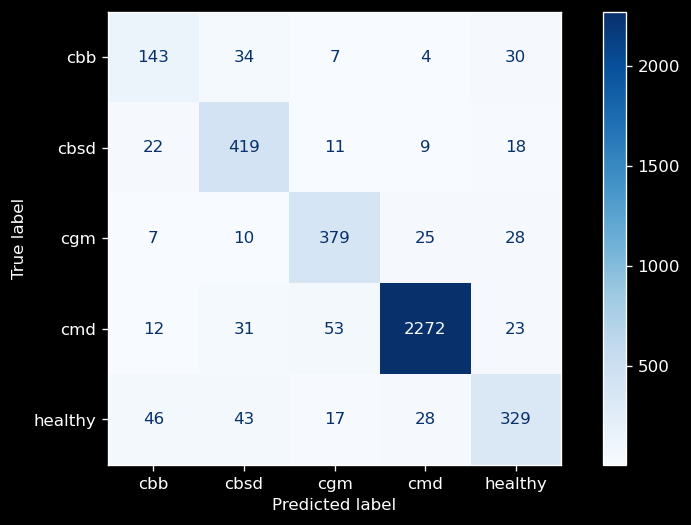

              precision    recall  f1-score   support

         cbb       0.62      0.66      0.64       218
        cbsd       0.78      0.87      0.82       479
         cgm       0.81      0.84      0.83       449
         cmd       0.97      0.95      0.96      2391
     healthy       0.77      0.71      0.74       463

    accuracy                           0.89      4000
   macro avg       0.79      0.81      0.80      4000
weighted avg       0.89      0.89      0.89      4000

------------




EPOCH #11



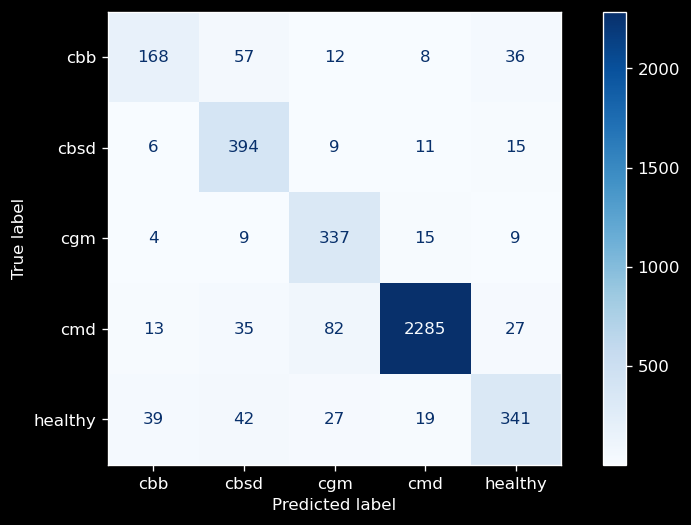

              precision    recall  f1-score   support

         cbb       0.73      0.60      0.66       281
        cbsd       0.73      0.91      0.81       435
         cgm       0.72      0.90      0.80       374
         cmd       0.98      0.94      0.96      2442
     healthy       0.80      0.73      0.76       468

    accuracy                           0.88      4000
   macro avg       0.79      0.81      0.80      4000
weighted avg       0.89      0.88      0.88      4000

------------




EPOCH #12



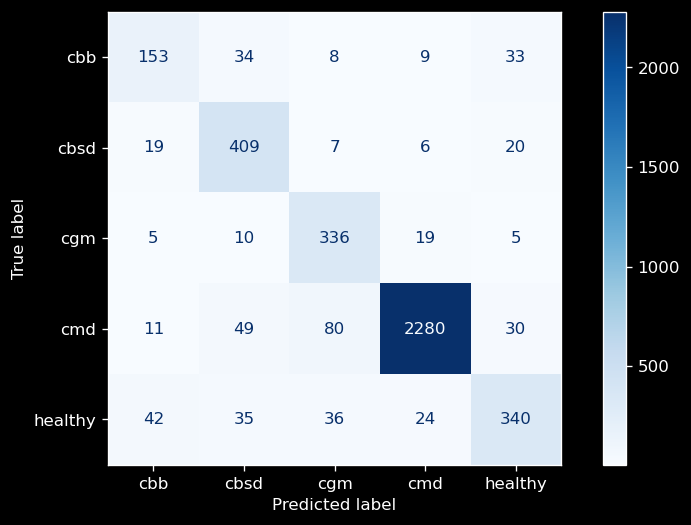

              precision    recall  f1-score   support

         cbb       0.67      0.65      0.66       237
        cbsd       0.76      0.89      0.82       461
         cgm       0.72      0.90      0.80       375
         cmd       0.98      0.93      0.95      2450
     healthy       0.79      0.71      0.75       477

    accuracy                           0.88      4000
   macro avg       0.78      0.81      0.80      4000
weighted avg       0.89      0.88      0.88      4000

------------




EPOCH #13



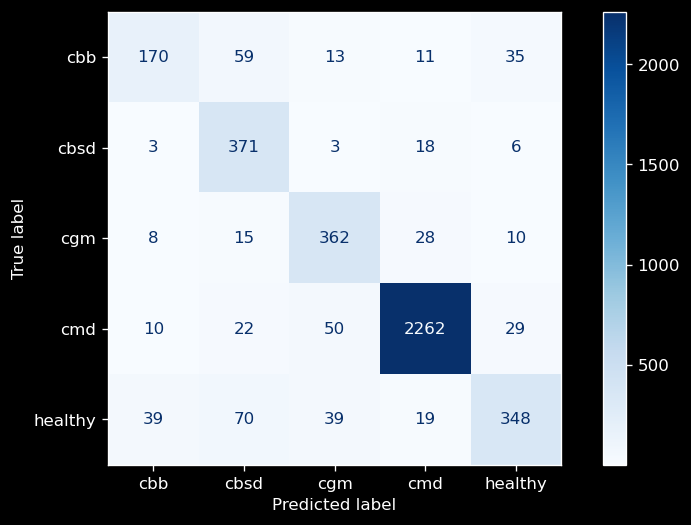

              precision    recall  f1-score   support

         cbb       0.74      0.59      0.66       288
        cbsd       0.69      0.93      0.79       401
         cgm       0.78      0.86      0.81       423
         cmd       0.97      0.95      0.96      2373
     healthy       0.81      0.68      0.74       515

    accuracy                           0.88      4000
   macro avg       0.80      0.80      0.79      4000
weighted avg       0.88      0.88      0.88      4000

------------




EPOCH #14



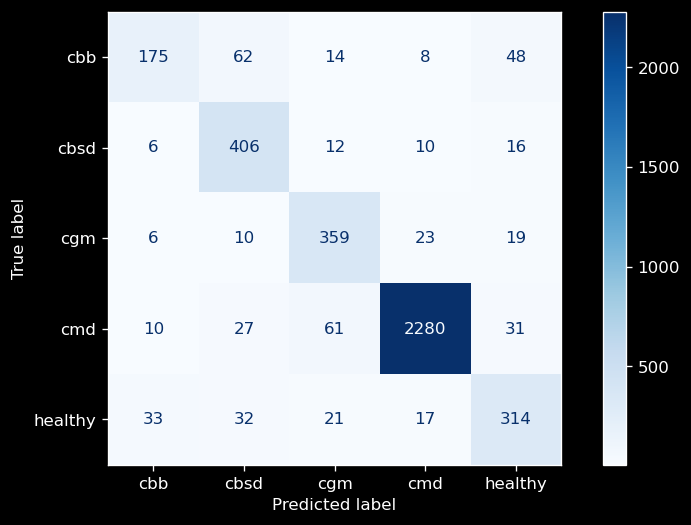

              precision    recall  f1-score   support

         cbb       0.76      0.57      0.65       307
        cbsd       0.76      0.90      0.82       450
         cgm       0.77      0.86      0.81       417
         cmd       0.98      0.95      0.96      2409
     healthy       0.73      0.75      0.74       417

    accuracy                           0.88      4000
   macro avg       0.80      0.81      0.80      4000
weighted avg       0.89      0.88      0.88      4000

------------




EPOCH #15



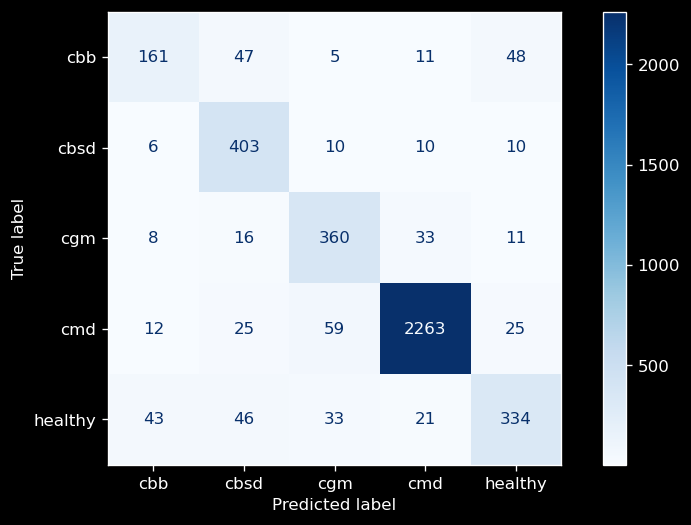

              precision    recall  f1-score   support

         cbb       0.70      0.59      0.64       272
        cbsd       0.75      0.92      0.83       439
         cgm       0.77      0.84      0.80       428
         cmd       0.97      0.95      0.96      2384
     healthy       0.78      0.70      0.74       477

    accuracy                           0.88      4000
   macro avg       0.79      0.80      0.79      4000
weighted avg       0.88      0.88      0.88      4000

------------




EPOCH #16



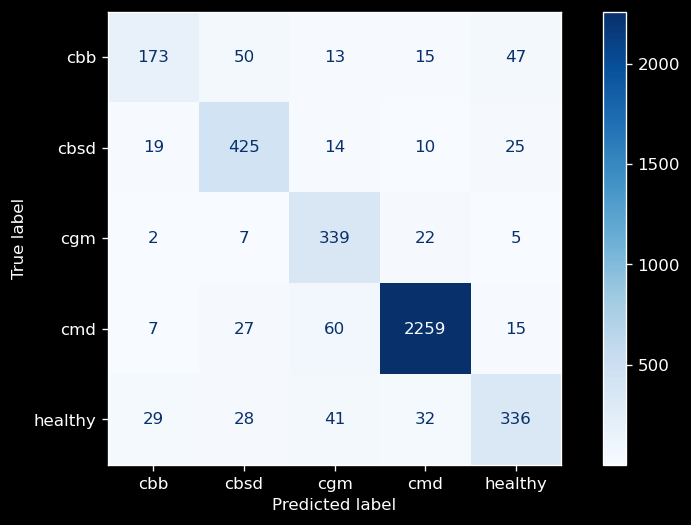

              precision    recall  f1-score   support

         cbb       0.75      0.58      0.66       298
        cbsd       0.79      0.86      0.83       493
         cgm       0.73      0.90      0.81       375
         cmd       0.97      0.95      0.96      2368
     healthy       0.79      0.72      0.75       466

    accuracy                           0.88      4000
   macro avg       0.80      0.80      0.80      4000
weighted avg       0.89      0.88      0.88      4000

------------




EPOCH #17



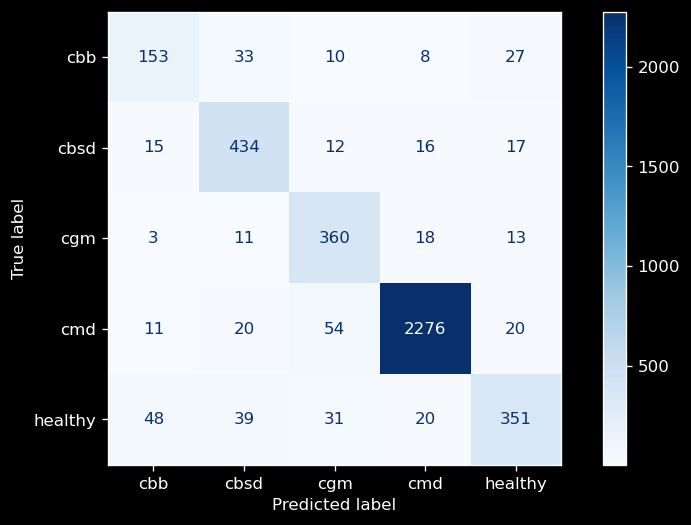

              precision    recall  f1-score   support

         cbb       0.67      0.66      0.66       231
        cbsd       0.81      0.88      0.84       494
         cgm       0.77      0.89      0.83       405
         cmd       0.97      0.96      0.96      2381
     healthy       0.82      0.72      0.77       489

    accuracy                           0.89      4000
   macro avg       0.81      0.82      0.81      4000
weighted avg       0.90      0.89      0.89      4000

------------




EPOCH #18



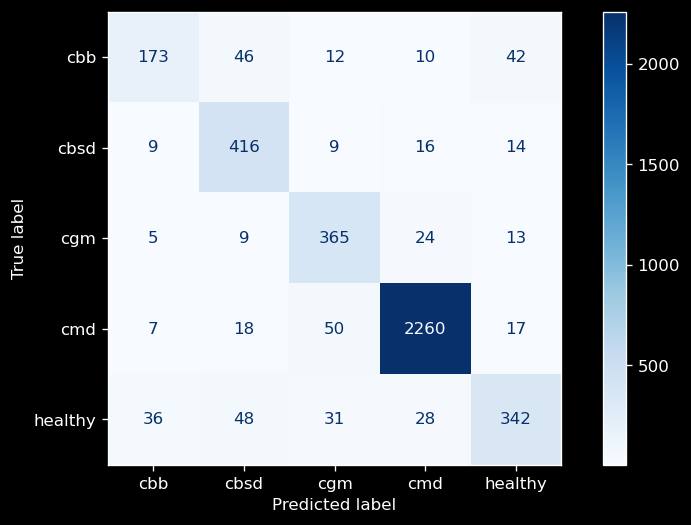

              precision    recall  f1-score   support

         cbb       0.75      0.61      0.67       283
        cbsd       0.77      0.90      0.83       464
         cgm       0.78      0.88      0.83       416
         cmd       0.97      0.96      0.96      2352
     healthy       0.80      0.71      0.75       485

    accuracy                           0.89      4000
   macro avg       0.81      0.81      0.81      4000
weighted avg       0.89      0.89      0.89      4000

------------




EPOCH #19



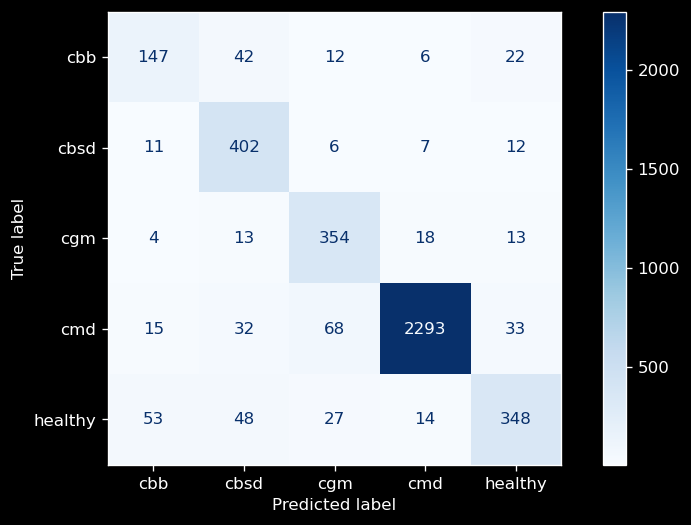

              precision    recall  f1-score   support

         cbb       0.64      0.64      0.64       229
        cbsd       0.75      0.92      0.82       438
         cgm       0.76      0.88      0.81       402
         cmd       0.98      0.94      0.96      2441
     healthy       0.81      0.71      0.76       490

    accuracy                           0.89      4000
   macro avg       0.79      0.82      0.80      4000
weighted avg       0.89      0.89      0.89      4000

------------




EPOCH #20



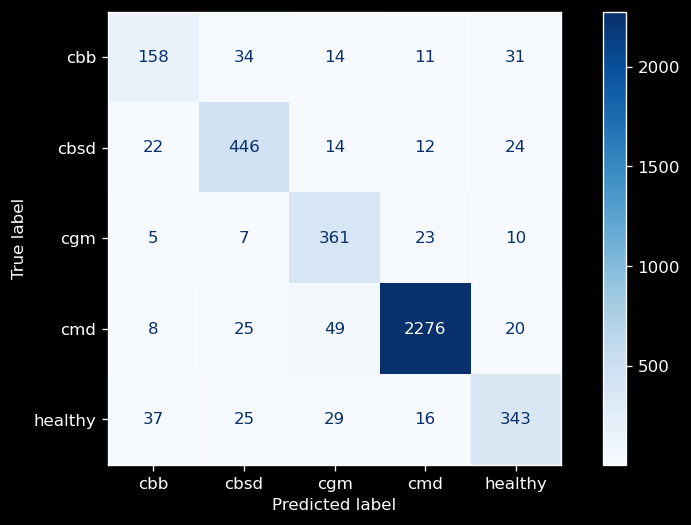

              precision    recall  f1-score   support

         cbb       0.69      0.64      0.66       248
        cbsd       0.83      0.86      0.85       518
         cgm       0.77      0.89      0.83       406
         cmd       0.97      0.96      0.97      2378
     healthy       0.80      0.76      0.78       450

    accuracy                           0.90      4000
   macro avg       0.81      0.82      0.82      4000
weighted avg       0.90      0.90      0.90      4000

------------




EPOCH #21



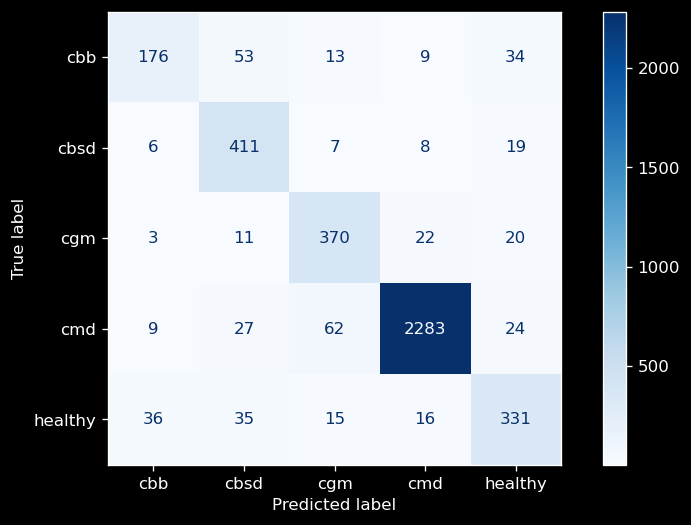

              precision    recall  f1-score   support

         cbb       0.77      0.62      0.68       285
        cbsd       0.77      0.91      0.83       451
         cgm       0.79      0.87      0.83       426
         cmd       0.98      0.95      0.96      2405
     healthy       0.77      0.76      0.77       433

    accuracy                           0.89      4000
   macro avg       0.81      0.82      0.82      4000
weighted avg       0.90      0.89      0.89      4000

------------




EPOCH #22



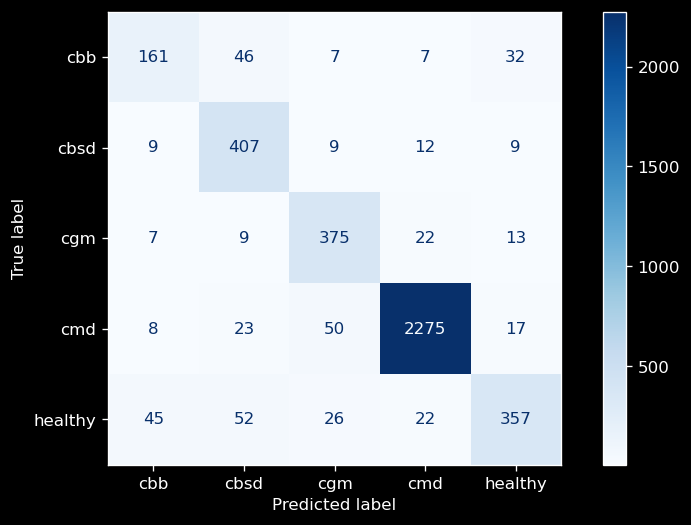

              precision    recall  f1-score   support

         cbb       0.70      0.64      0.67       253
        cbsd       0.76      0.91      0.83       446
         cgm       0.80      0.88      0.84       426
         cmd       0.97      0.96      0.97      2373
     healthy       0.83      0.71      0.77       502

    accuracy                           0.89      4000
   macro avg       0.81      0.82      0.81      4000
weighted avg       0.90      0.89      0.89      4000

------------




EPOCH #23



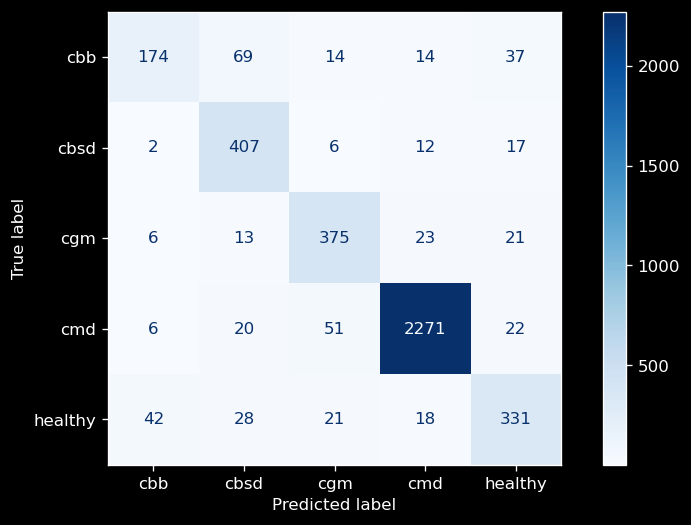

              precision    recall  f1-score   support

         cbb       0.76      0.56      0.65       308
        cbsd       0.76      0.92      0.83       444
         cgm       0.80      0.86      0.83       438
         cmd       0.97      0.96      0.96      2370
     healthy       0.77      0.75      0.76       440

    accuracy                           0.89      4000
   macro avg       0.81      0.81      0.81      4000
weighted avg       0.89      0.89      0.89      4000

------------




EPOCH #24



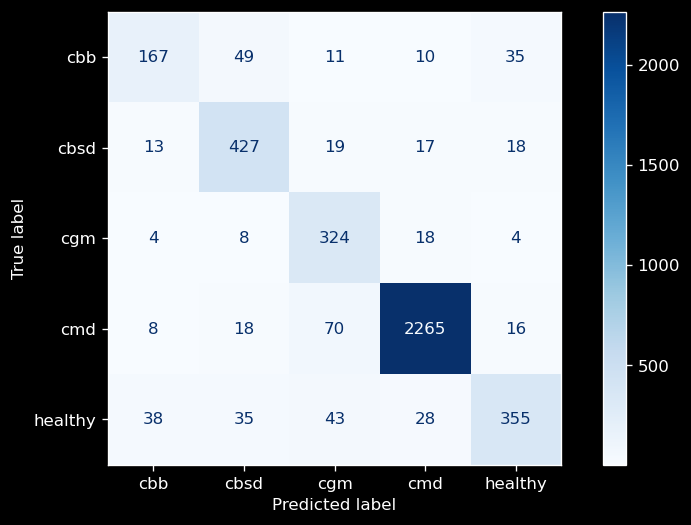

              precision    recall  f1-score   support

         cbb       0.73      0.61      0.67       272
        cbsd       0.80      0.86      0.83       494
         cgm       0.69      0.91      0.79       358
         cmd       0.97      0.95      0.96      2377
     healthy       0.83      0.71      0.77       499

    accuracy                           0.88      4000
   macro avg       0.80      0.81      0.80      4000
weighted avg       0.89      0.88      0.88      4000

------------




EPOCH #25



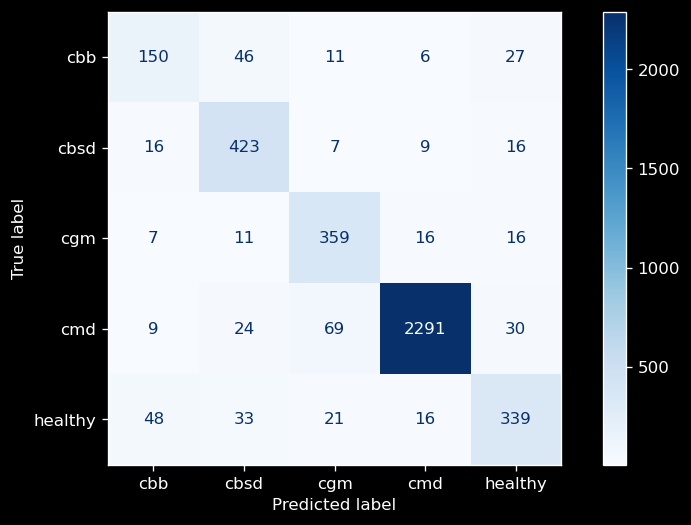

              precision    recall  f1-score   support

         cbb       0.65      0.62      0.64       240
        cbsd       0.79      0.90      0.84       471
         cgm       0.77      0.88      0.82       409
         cmd       0.98      0.95      0.96      2423
     healthy       0.79      0.74      0.77       457

    accuracy                           0.89      4000
   macro avg       0.80      0.82      0.81      4000
weighted avg       0.89      0.89      0.89      4000

------------




EPOCH #26



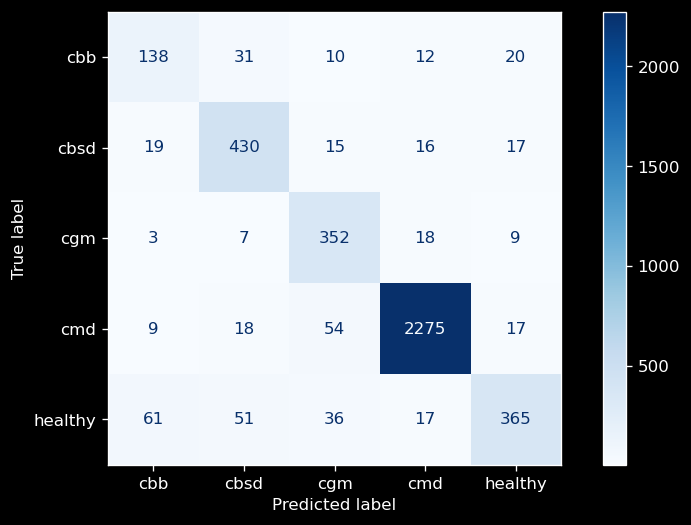

              precision    recall  f1-score   support

         cbb       0.60      0.65      0.63       211
        cbsd       0.80      0.87      0.83       497
         cgm       0.75      0.90      0.82       389
         cmd       0.97      0.96      0.97      2373
     healthy       0.85      0.69      0.76       530

    accuracy                           0.89      4000
   macro avg       0.80      0.81      0.80      4000
weighted avg       0.89      0.89      0.89      4000

------------




EPOCH #27



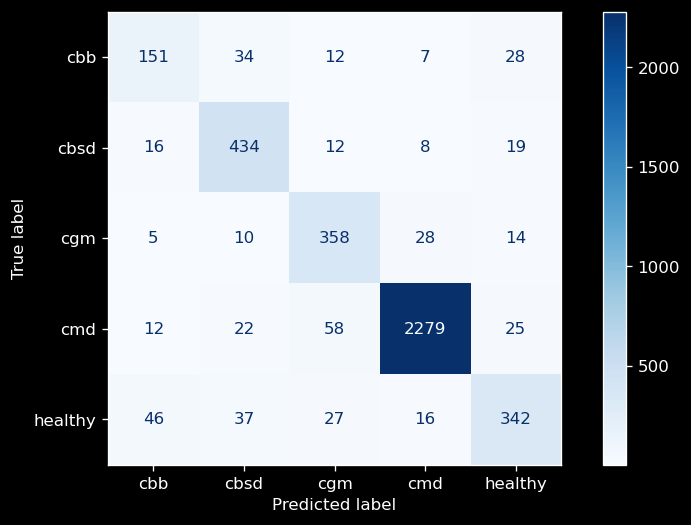

              precision    recall  f1-score   support

         cbb       0.66      0.65      0.65       232
        cbsd       0.81      0.89      0.85       489
         cgm       0.77      0.86      0.81       415
         cmd       0.97      0.95      0.96      2396
     healthy       0.80      0.73      0.76       468

    accuracy                           0.89      4000
   macro avg       0.80      0.82      0.81      4000
weighted avg       0.89      0.89      0.89      4000

------------




EPOCH #28



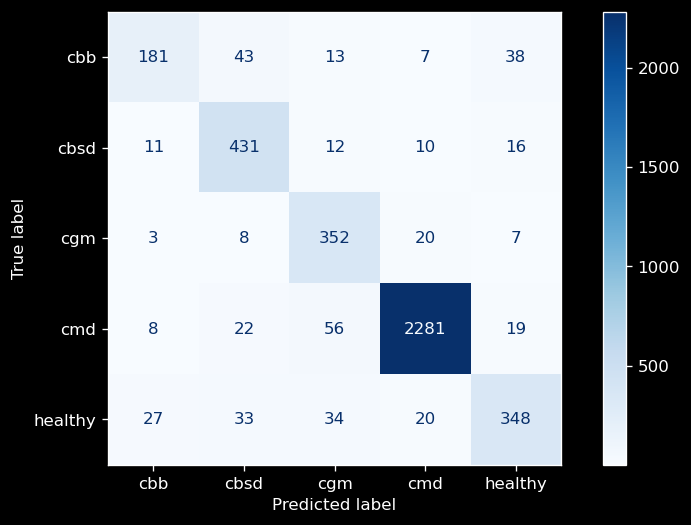

              precision    recall  f1-score   support

         cbb       0.79      0.64      0.71       282
        cbsd       0.80      0.90      0.85       480
         cgm       0.75      0.90      0.82       390
         cmd       0.98      0.96      0.97      2386
     healthy       0.81      0.75      0.78       462

    accuracy                           0.90      4000
   macro avg       0.83      0.83      0.82      4000
weighted avg       0.90      0.90      0.90      4000

------------




EPOCH #29



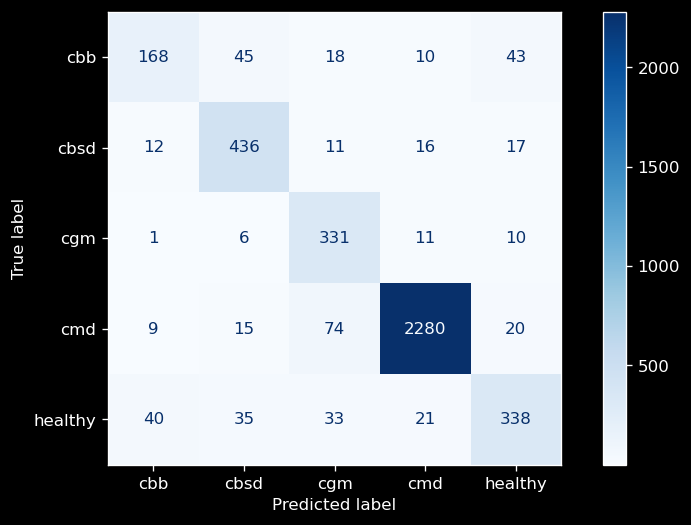

              precision    recall  f1-score   support

         cbb       0.73      0.59      0.65       284
        cbsd       0.81      0.89      0.85       492
         cgm       0.71      0.92      0.80       359
         cmd       0.98      0.95      0.96      2398
     healthy       0.79      0.72      0.76       467

    accuracy                           0.89      4000
   macro avg       0.80      0.81      0.80      4000
weighted avg       0.89      0.89      0.89      4000

------------




EPOCH #30



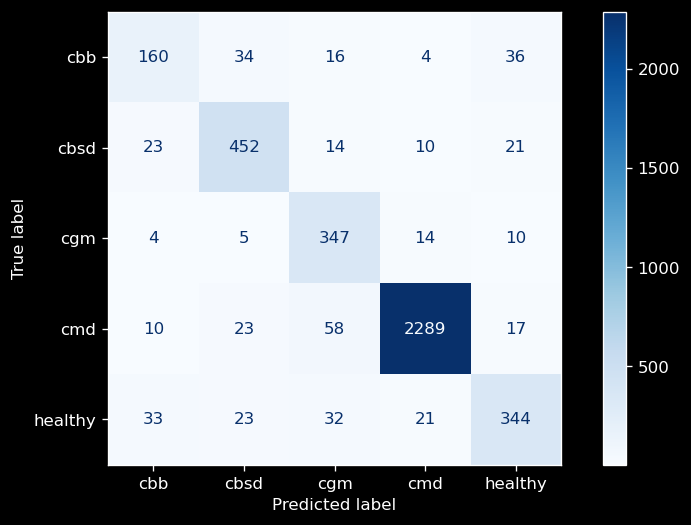

              precision    recall  f1-score   support

         cbb       0.70      0.64      0.67       250
        cbsd       0.84      0.87      0.86       520
         cgm       0.74      0.91      0.82       380
         cmd       0.98      0.95      0.97      2397
     healthy       0.80      0.76      0.78       453

    accuracy                           0.90      4000
   macro avg       0.81      0.83      0.82      4000
weighted avg       0.90      0.90      0.90      4000

------------




EPOCH #31



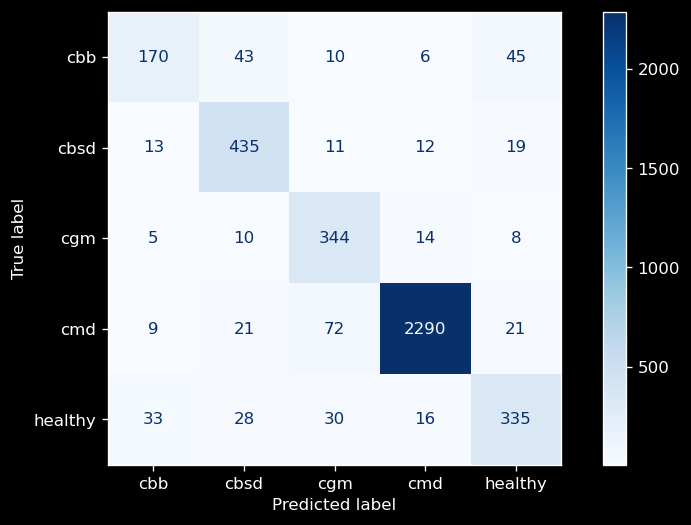

              precision    recall  f1-score   support

         cbb       0.74      0.62      0.67       274
        cbsd       0.81      0.89      0.85       490
         cgm       0.74      0.90      0.81       381
         cmd       0.98      0.95      0.96      2413
     healthy       0.78      0.76      0.77       442

    accuracy                           0.89      4000
   macro avg       0.81      0.82      0.81      4000
weighted avg       0.90      0.89      0.89      4000

------------




EPOCH #32



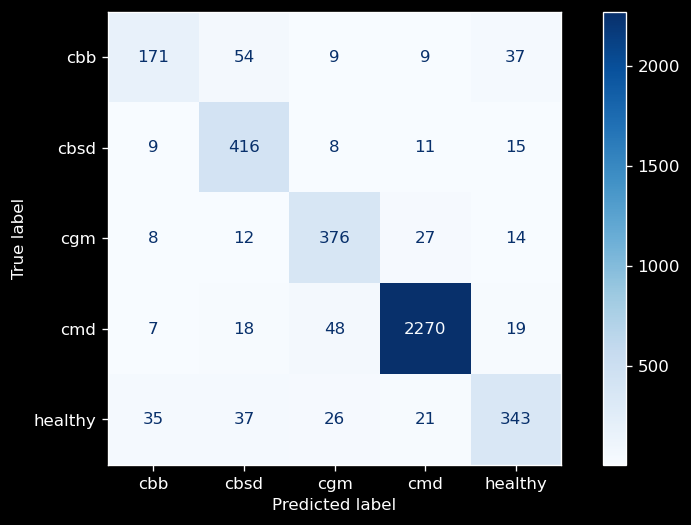

              precision    recall  f1-score   support

         cbb       0.74      0.61      0.67       280
        cbsd       0.77      0.91      0.84       459
         cgm       0.81      0.86      0.83       437
         cmd       0.97      0.96      0.97      2362
     healthy       0.80      0.74      0.77       462

    accuracy                           0.89      4000
   macro avg       0.82      0.82      0.81      4000
weighted avg       0.89      0.89      0.89      4000

------------




EPOCH #33



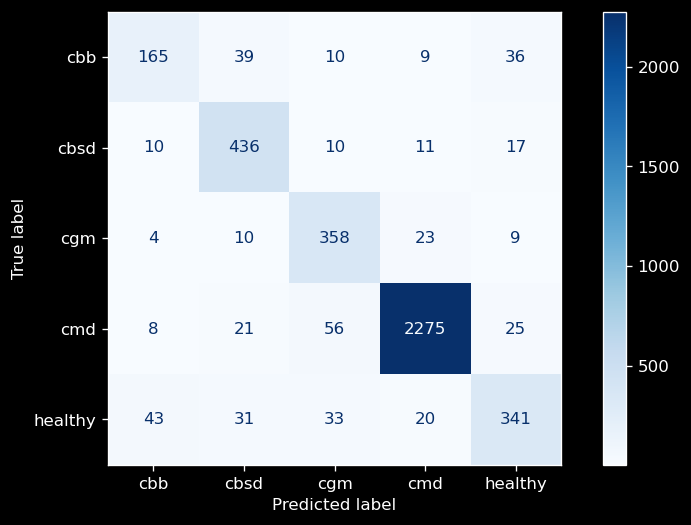

              precision    recall  f1-score   support

         cbb       0.72      0.64      0.67       259
        cbsd       0.81      0.90      0.85       484
         cgm       0.77      0.89      0.82       404
         cmd       0.97      0.95      0.96      2385
     healthy       0.80      0.73      0.76       468

    accuracy                           0.89      4000
   macro avg       0.81      0.82      0.82      4000
weighted avg       0.90      0.89      0.89      4000

------------




EPOCH #34



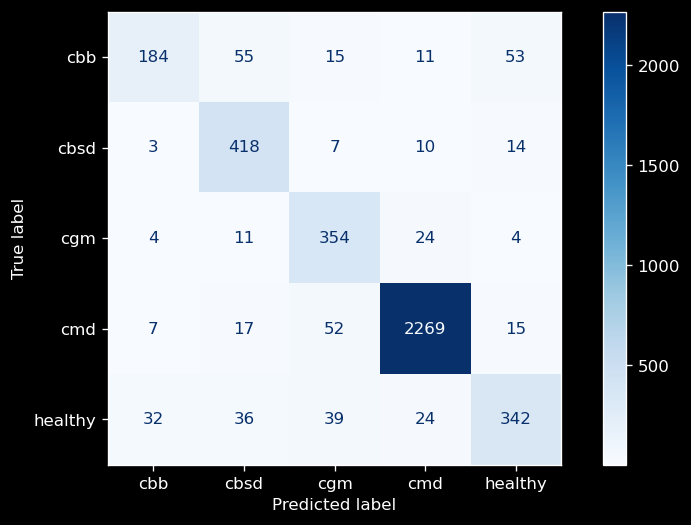

              precision    recall  f1-score   support

         cbb       0.80      0.58      0.67       318
        cbsd       0.78      0.92      0.85       452
         cgm       0.76      0.89      0.82       397
         cmd       0.97      0.96      0.97      2360
     healthy       0.80      0.72      0.76       473

    accuracy                           0.89      4000
   macro avg       0.82      0.82      0.81      4000
weighted avg       0.89      0.89      0.89      4000

------------




EPOCH #35



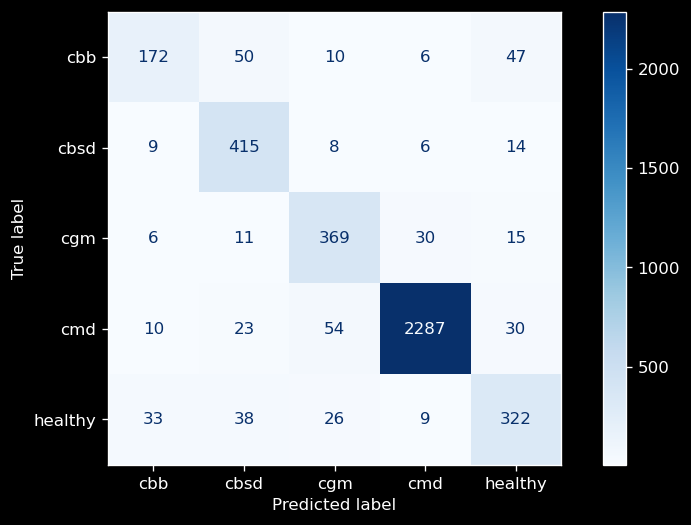

              precision    recall  f1-score   support

         cbb       0.75      0.60      0.67       285
        cbsd       0.77      0.92      0.84       452
         cgm       0.79      0.86      0.82       431
         cmd       0.98      0.95      0.96      2404
     healthy       0.75      0.75      0.75       428

    accuracy                           0.89      4000
   macro avg       0.81      0.82      0.81      4000
weighted avg       0.89      0.89      0.89      4000

------------




EPOCH #36



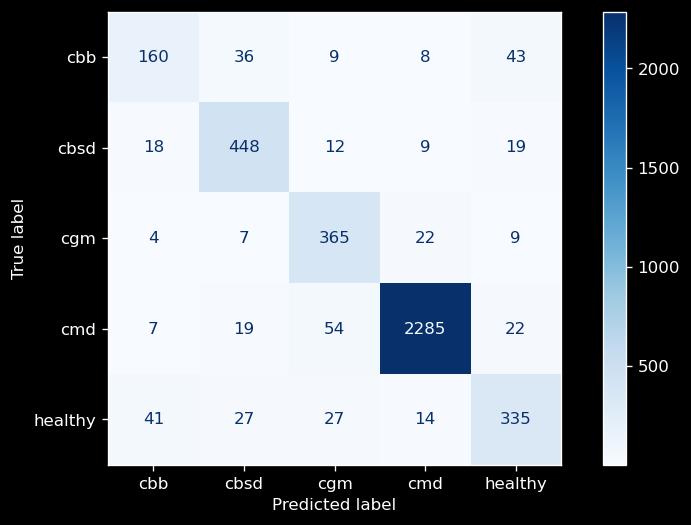

              precision    recall  f1-score   support

         cbb       0.70      0.62      0.66       256
        cbsd       0.83      0.89      0.86       506
         cgm       0.78      0.90      0.84       407
         cmd       0.98      0.96      0.97      2387
     healthy       0.78      0.75      0.77       444

    accuracy                           0.90      4000
   macro avg       0.81      0.82      0.82      4000
weighted avg       0.90      0.90      0.90      4000

------------




EPOCH #37



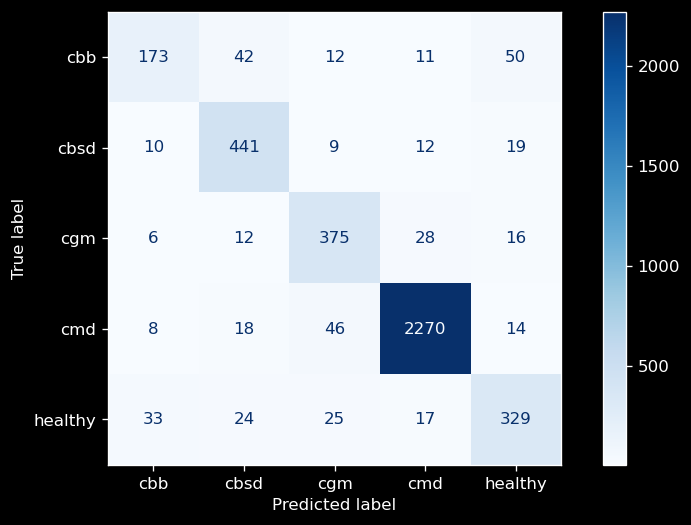

              precision    recall  f1-score   support

         cbb       0.75      0.60      0.67       288
        cbsd       0.82      0.90      0.86       491
         cgm       0.80      0.86      0.83       437
         cmd       0.97      0.96      0.97      2356
     healthy       0.77      0.77      0.77       428

    accuracy                           0.90      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.90      0.90      0.90      4000

------------




EPOCH #38



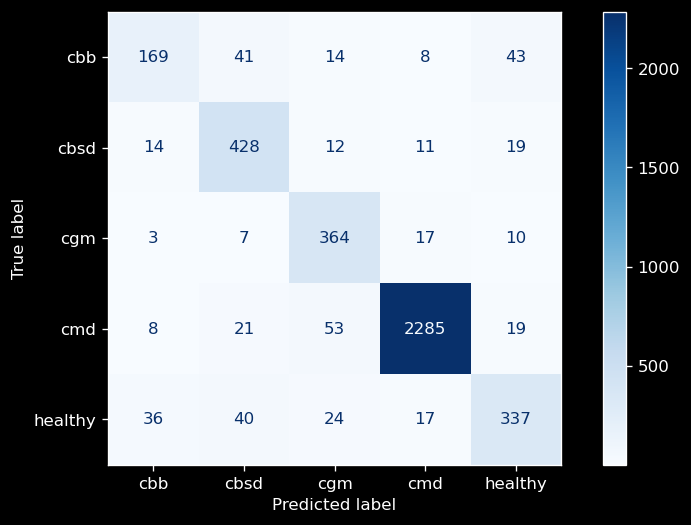

              precision    recall  f1-score   support

         cbb       0.73      0.61      0.67       275
        cbsd       0.80      0.88      0.84       484
         cgm       0.78      0.91      0.84       401
         cmd       0.98      0.96      0.97      2386
     healthy       0.79      0.74      0.76       454

    accuracy                           0.90      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.90      0.90      0.90      4000

------------




EPOCH #39



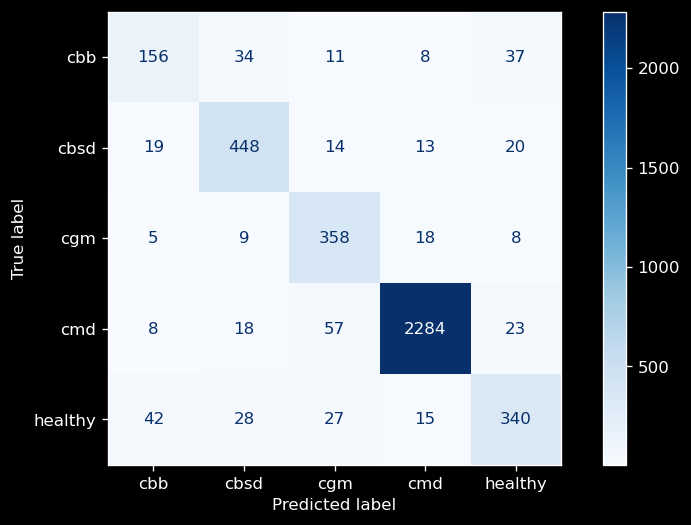

              precision    recall  f1-score   support

         cbb       0.68      0.63      0.66       246
        cbsd       0.83      0.87      0.85       514
         cgm       0.77      0.90      0.83       398
         cmd       0.98      0.96      0.97      2390
     healthy       0.79      0.75      0.77       452

    accuracy                           0.90      4000
   macro avg       0.81      0.82      0.81      4000
weighted avg       0.90      0.90      0.90      4000

------------




EPOCH #40



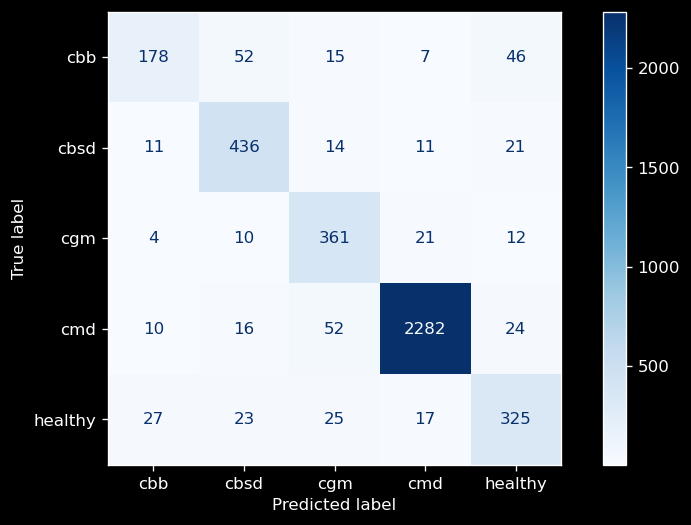

              precision    recall  f1-score   support

         cbb       0.77      0.60      0.67       298
        cbsd       0.81      0.88      0.85       493
         cgm       0.77      0.88      0.83       408
         cmd       0.98      0.96      0.97      2384
     healthy       0.76      0.78      0.77       417

    accuracy                           0.90      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.90      0.90      0.89      4000

------------




EPOCH #41



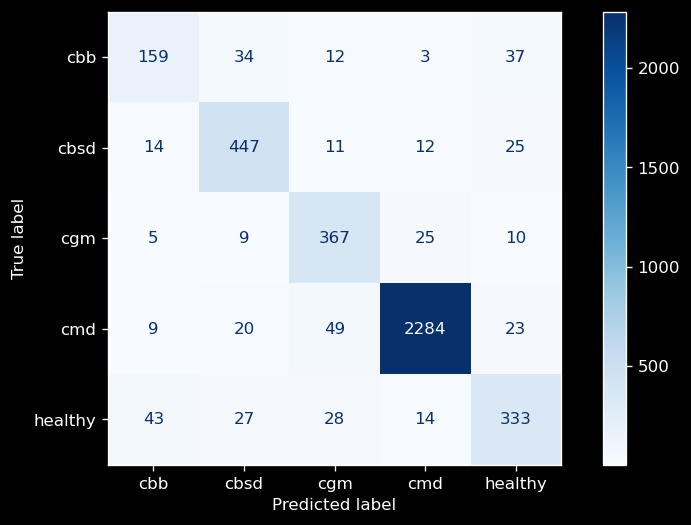

              precision    recall  f1-score   support

         cbb       0.69      0.65      0.67       245
        cbsd       0.83      0.88      0.85       509
         cgm       0.79      0.88      0.83       416
         cmd       0.98      0.96      0.97      2385
     healthy       0.78      0.75      0.76       445

    accuracy                           0.90      4000
   macro avg       0.81      0.82      0.82      4000
weighted avg       0.90      0.90      0.90      4000

------------




EPOCH #42



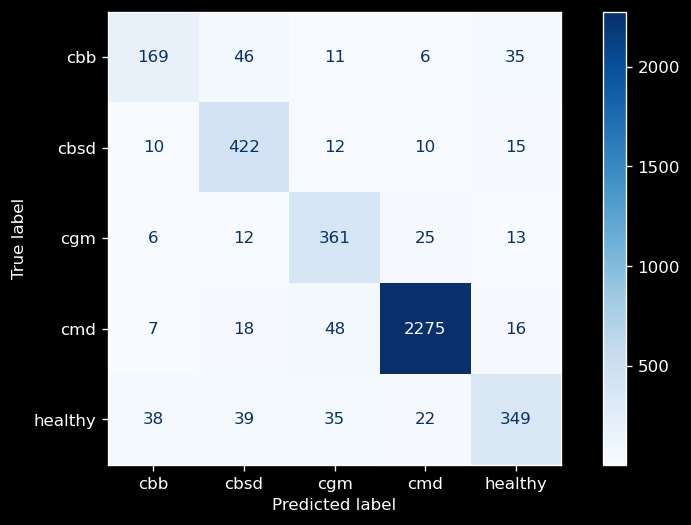

              precision    recall  f1-score   support

         cbb       0.73      0.63      0.68       267
        cbsd       0.79      0.90      0.84       469
         cgm       0.77      0.87      0.82       417
         cmd       0.97      0.96      0.97      2364
     healthy       0.82      0.72      0.77       483

    accuracy                           0.89      4000
   macro avg       0.82      0.82      0.81      4000
weighted avg       0.90      0.89      0.89      4000

------------




EPOCH #43



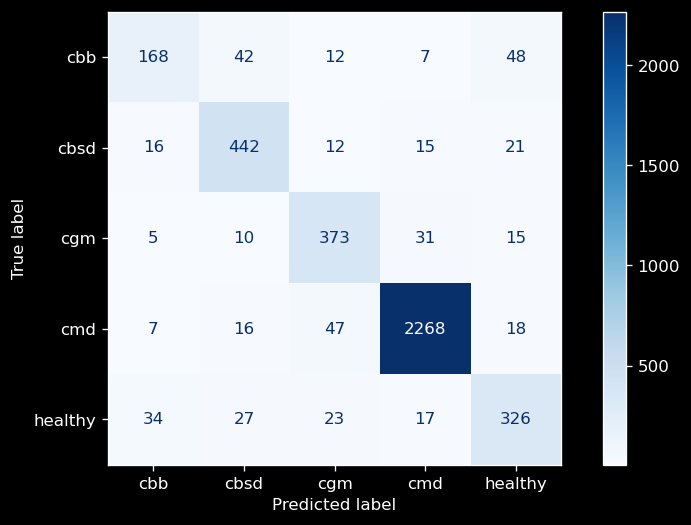

              precision    recall  f1-score   support

         cbb       0.73      0.61      0.66       277
        cbsd       0.82      0.87      0.85       506
         cgm       0.80      0.86      0.83       434
         cmd       0.97      0.96      0.97      2356
     healthy       0.76      0.76      0.76       427

    accuracy                           0.89      4000
   macro avg       0.82      0.81      0.81      4000
weighted avg       0.89      0.89      0.89      4000

------------




EPOCH #44



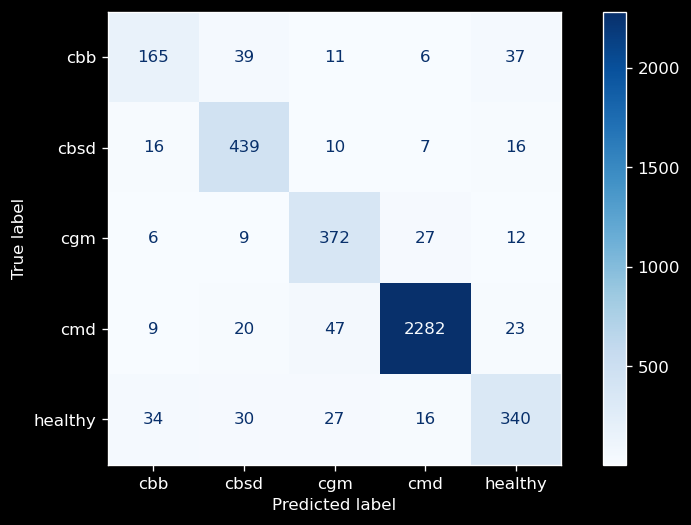

              precision    recall  f1-score   support

         cbb       0.72      0.64      0.68       258
        cbsd       0.82      0.90      0.86       488
         cgm       0.80      0.87      0.83       426
         cmd       0.98      0.96      0.97      2381
     healthy       0.79      0.76      0.78       447

    accuracy                           0.90      4000
   macro avg       0.82      0.83      0.82      4000
weighted avg       0.90      0.90      0.90      4000

------------




EPOCH #45



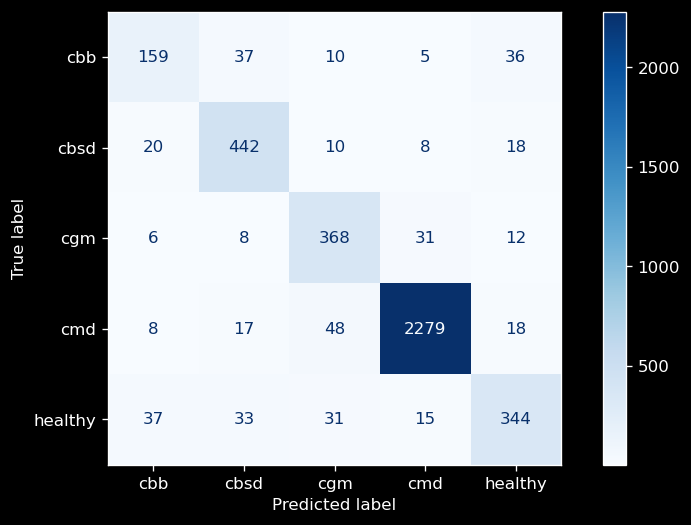

              precision    recall  f1-score   support

         cbb       0.69      0.64      0.67       247
        cbsd       0.82      0.89      0.85       498
         cgm       0.79      0.87      0.83       425
         cmd       0.97      0.96      0.97      2370
     healthy       0.80      0.75      0.77       460

    accuracy                           0.90      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.90      0.90      0.90      4000

------------




EPOCH #46



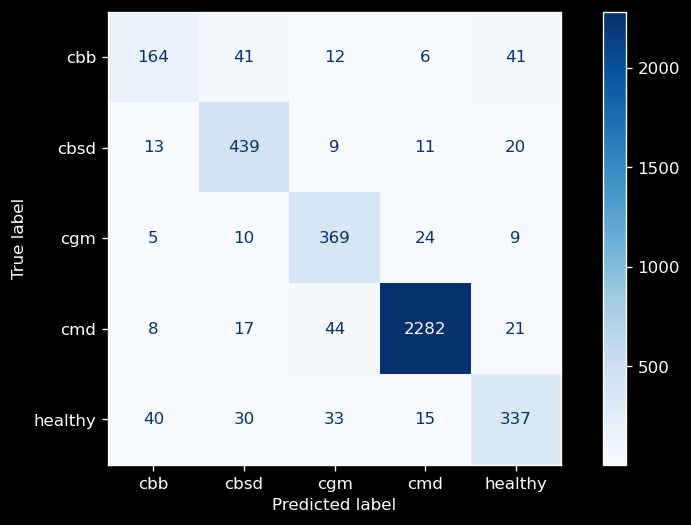

              precision    recall  f1-score   support

         cbb       0.71      0.62      0.66       264
        cbsd       0.82      0.89      0.85       492
         cgm       0.79      0.88      0.83       417
         cmd       0.98      0.96      0.97      2372
     healthy       0.79      0.74      0.76       455

    accuracy                           0.90      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.90      0.90      0.90      4000

------------




EPOCH #47



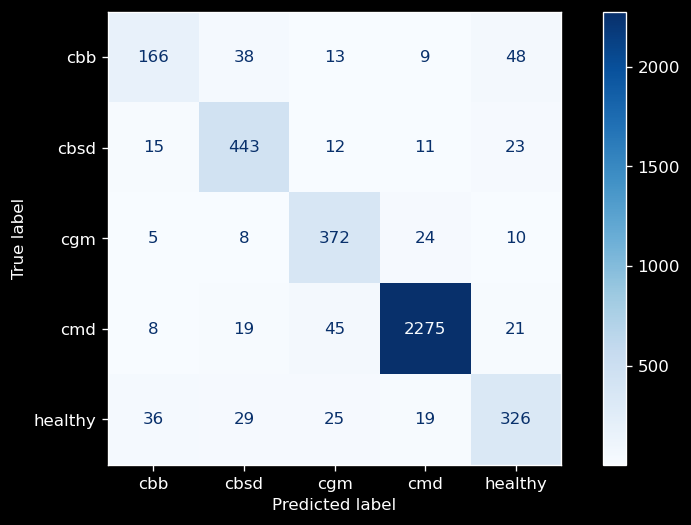

              precision    recall  f1-score   support

         cbb       0.72      0.61      0.66       274
        cbsd       0.82      0.88      0.85       504
         cgm       0.80      0.89      0.84       419
         cmd       0.97      0.96      0.97      2368
     healthy       0.76      0.75      0.76       435

    accuracy                           0.90      4000
   macro avg       0.82      0.82      0.81      4000
weighted avg       0.90      0.90      0.89      4000

------------




EPOCH #48



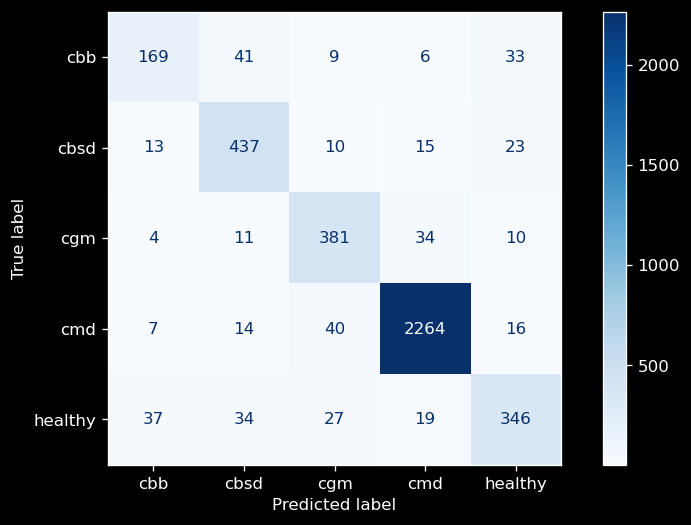

              precision    recall  f1-score   support

         cbb       0.73      0.66      0.69       258
        cbsd       0.81      0.88      0.84       498
         cgm       0.82      0.87      0.84       440
         cmd       0.97      0.97      0.97      2341
     healthy       0.81      0.75      0.78       463

    accuracy                           0.90      4000
   macro avg       0.83      0.82      0.82      4000
weighted avg       0.90      0.90      0.90      4000

------------




EPOCH #49



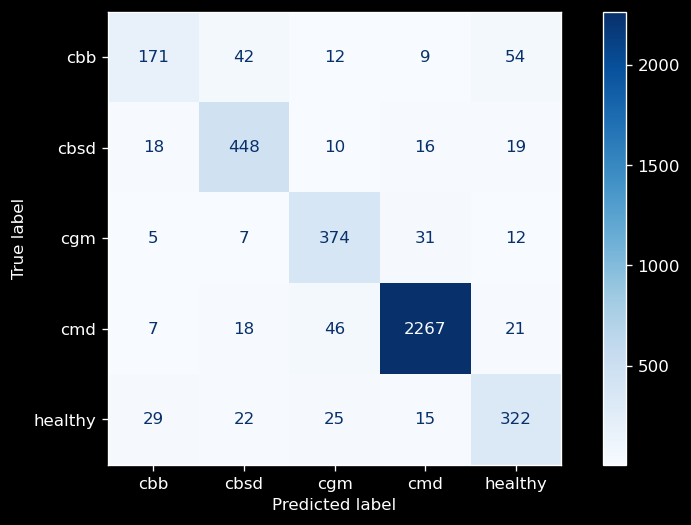

              precision    recall  f1-score   support

         cbb       0.74      0.59      0.66       288
        cbsd       0.83      0.88      0.85       511
         cgm       0.80      0.87      0.83       429
         cmd       0.97      0.96      0.97      2359
     healthy       0.75      0.78      0.77       413

    accuracy                           0.90      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.90      0.90      0.89      4000

------------


In [57]:
import pyforest

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay



#test_learn = load_learner(f'../models/{RUN_NAME}.pkl', cpu=False)
#test_learn = learn
learn.remove_cbs([ModelToHalf, NonNativeMixedPrecision])

for num in range(10,EPOCHS):
    load_model(f'models/{RUN_NAME}_{num}.pth', learn, opt=ranger, with_opt=False)

    preds, targs = learn.tta(ds_idx=2, n=4)
    matrix = confusion_matrix(preds.argmax(dim=-1), targs)

    print(f'\n\nEPOCH #{num}\n')
    matrix_plot = ConfusionMatrixDisplay(matrix, display_labels=classes)
    matrix_plot.plot(cmap='Blues')


    plt.show()
    print(classification_report(preds.argmax(dim=-1), targs,target_names=classes))

    print('------------')

In [1]:
# get the label from any image path  @TODO sloooooowwwwww......

def get_label(o):
    fname = o.name
    if fname in df.image_id.values:
        return df[df.image_id == fname].label.values[0]
    if fname in ensemble_train_df.image_id.values:
        return ensemble_train_df[ensemble_train_df.image_id == fname].label.values[0]


In [2]:
import sys
sys.path.append('../../utils')

from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from string import ascii_uppercase
import numpy as np
import operator
import glob

import torch
from torch import nn as nn
from torch.nn import functional as F

import gc
# from cassava_utils_eff import *
from nn_utils_eff import *
# from pip_augs import *
from augmentation import *

%matplotlib inline
# %matplotlib widget

plt.rcParams['figure.figsize'] = [9, 5]
plt.rcParams['figure.dpi'] = 120
plt.style.use('dark_background')

import warnings
warnings.filterwarnings('ignore')  # or 'once'  


data_path = Path('../../data')


In [6]:
import pyforest

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

RUN_NAME = '20210329-1845 - arch=tf_efficientnet_b4_ns - samples=-1 frozen=1 epochs=50 bs=48 res=380'


learn = load_learner(f'../../models/{RUN_NAME}.pkl', cpu=False)
#test_learn = learn
c = remove_cbs(learn)
learn.remove_cbs([ModelToHalf, NonNativeMixedPrecision])
with open(f'../models/DLS/{RUN_NAME}-DLS.pkl', 'rb') as f:
    dls = pickle.load(f)
learn.dls = dls.cuda()

for num in range(50):
    load_model(f'../models/{RUN_NAME}_{num}.pth', learn, opt=ranger, with_opt=False)
    

    preds, targs = learn.tta(ds_idx=2, n=4)
    matrix = confusion_matrix(preds.argmax(dim=-1), targs)

    print(f'\n\nEPOCH #{num}\n')
    matrix_plot = ConfusionMatrixDisplay(matrix, display_labels=classes)
    matrix_plot.plot(cmap='Blues')


    plt.show()
    print(classification_report(preds.argmax(dim=-1), targs,target_names=classes))

    print('------------')

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 34, in fetch
    data = next(self.dataset_iter)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastai/data/load.py", line 110, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastcore/basics.py", line 216, in chunked
    res = list(itertools.islice(it, chunk_sz))
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastai/data/load.py", line 125, in do_item
    try: return self.after_item(self.create_item(s))
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastai/data/load.py", line 131, in create_item
    def create_item(self, s):  return next(self.it) if s is None else self.dataset[s]
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastai/data/core.py", line 314, in __getitem__
    res = tuple([tl[it] for tl in self.tls])
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastai/data/core.py", line 314, in <listcomp>
    res = tuple([tl[it] for tl in self.tls])
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastai/data/core.py", line 280, in __getitem__
    return self._after_item(res) if is_indexer(idx) else res.map(self._after_item)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastai/data/core.py", line 242, in _after_item
    def _after_item(self, o): return self.tfms(o)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastcore/transform.py", line 198, in __call__
    def __call__(self, o): return compose_tfms(o, tfms=self.fs, split_idx=self.split_idx)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastcore/transform.py", line 150, in compose_tfms
    x = f(x, **kwargs)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastcore/transform.py", line 73, in __call__
    def __call__(self, x, **kwargs): return self._call('encodes', x, **kwargs)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastcore/transform.py", line 83, in _call
    return self._do_call(getattr(self, fn), x, **kwargs)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastcore/transform.py", line 89, in _do_call
    return retain_type(f(x, **kwargs), x, ret)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastcore/dispatch.py", line 118, in __call__
    return f(*args, **kwargs)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastai/vision/core.py", line 110, in create
    return cls(load_image(fn, **merge(cls._open_args, kwargs)))
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastai/vision/core.py", line 85, in load_image
    im = Image.open(fn)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/PIL/Image.py", line 2904, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '/home/frank/Insync/cogsci2@gmail.com/Google Drive/Study Notes/00-Personal Repos/Kaggle Cassava Disease Competition 2021/notebooks/data/train_images/1938715150.jpg'
